# Applications

## Get Ready



In [1]:
from qiskit import IBMQ, execute, Aer
from qiskit import transpile, assemble
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from scipy.optimize import minimize
from mitiq import zne
from qiskit.providers.aer.noise import NoiseModel
from qiskit import execute
from abc import ABC, abstractmethod
import json
import qiskit_aer.noise as noise
from typing import Dict, List, Optional, Union
import networkx as nx
import numpy as np
from docplex.mp.model import Model
from qiskit_optimization.algorithms import OptimizationResult
from qiskit_optimization.problems.quadratic_program import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.applications.graph_optimization_application import GraphOptimizationApplication
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import random
import warnings
import pandas as pd
import networkx as nx
warnings.simplefilter(action="ignore")

from time import time

# replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
IBMQ.save_account("TOKEN", overwrite=True) 
account = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')


In [32]:
def select_heroes(size):
     return dict(item for cnt, item in enumerate({
        'MEDUSA/MEDUSALITH AM': 0,
        'ARCLIGHT/PHILLIPA SO': 1,
        'WOLVERINE/LOGAN ': 2,
        'SCARLET WITCH/WANDA ': 3,
        'ARAGORN': 4,
        'OVERMIND/GROM': 5,
        'BATTLEAXE/': 6,
        'ION/': 7,
        'PINK PEARL/': 8,
        "BLACK PANTHER/T'CHAL": 9,
        'PRINCESS ZANDA': 10,
        'INFERNO III/SAMANTHA': 11,
        'MOTHER NIGHT/SUSAN S': 12,
        'VIPER II': 13,
        'IRON MAIDEN/': 14,
        'CARNIVORE/COUNT ANDR': 15,
        'HULK III/BRUCE BANNE': 16,
        'DEADPOOL/JACK/WADE W': 17,
        'BLIND AL/ALTHEA': 18,
        'WEASEL/JACK HAMMER': 19,
        'MONTGOMERY': 20
    }.items()) if cnt < size)
#CAPTION Select a subset of heroes

def use_network(size):
    data = pd.read_csv('./data/hero-network.csv')
    heroes = select_heroes(size)
    
    # filter the relations from the raw data
    relations = data[(data.hero1.isin(heroes.keys())) & (data.hero2.isin(heroes.keys()))]
    relations = pd.DataFrame(np.sort(relations.values, axis=1), columns=relations.columns)

    # build unique relations with counts
    relations['relation'] = [' - '.join(x) for x in np.sort(relations.to_numpy(), axis=1)]    
    summed_relations = relations.groupby(['relation']).size().reset_index().rename(columns={0:'count'})
    summed_relations = pd.merge(summed_relations, relations, on='relation', how='right').drop_duplicates(subset=['hero1', 'hero2'])

    # count the overall appearences of the heroes
    count_series1 = data.groupby(['hero1']).size()
    count_series2 = data.groupby(['hero2']).size()
    appearences = count_series1.add(count_series2, fill_value=0)

    # create the graph
    graph = nx.Graph()
    graph.add_nodes_from(heroes.values())
    graph.add_edges_from([(
            heroes[rel[1][2]],
            heroes[rel[1][3]]
        ) for rel in summed_relations.iterrows()])

    # add node weight
    for hero in heroes:
        graph.nodes[heroes[hero]]["weight"] = appearences[hero]
        graph.nodes[heroes[hero]]["name"] = hero
    
    # add edge weights
    edge_weights = dict((
            (heroes[rel[1][2]], heroes[rel[1][3]]),
            rel[1][1]
        ) for rel in summed_relations.iterrows())
    nx.set_edge_attributes(graph, edge_weights, "weight")
    
    return graph
#CAPTION Create the network graph

def draw_graph(graph, solution=None, seed=None):
    labels = dict( (key, f"{key}-{val:.0f}") for (key, val) in nx.get_node_attributes(graph, 'weight').items())
    edge_labels = nx.get_edge_attributes(graph, 'connections')
    
    plt.figure(1,figsize=(22,8)) 
    plt.tight_layout()
    plt.subplots_adjust(bottom=-.5, right=0.5, left=-.5)

    node_color = ["#CCC" if solution[-1-i] == '0' else "#555" for i in range(len(solution))] if solution is not None else "#CCC"
    
    pos = nx.spring_layout(graph, seed=seed)
    nx.draw_networkx_nodes(graph, pos=pos, node_color=node_color, node_size=1600)
    nx.draw_networkx_edges(graph, pos, width=4, edge_color ="#555")
    nx.draw_networkx_labels(graph,pos=pos, labels=labels, font_color="#000", font_size=20)
    nx.draw_networkx_edge_labels(graph, edge_labels=edge_labels, pos=pos)
    plt.show()
#CAPTION Draw the simple graph

In [33]:
class Cache(ABC):
    def __init__(self, execute_to_job):
        self._execute_to_job = execute_to_job
        
    @abstractmethod
    def use(self, beta, gamma, circuits):
        pass
    
    @abstractmethod
    def stats(self):
        pass

class InMemoryCache(Cache):
    def __init__(self, execute_to_job, debug=True):
        super().__init__(execute_to_job)
        self._cache = []
        self._count_execs = 0
        self._count_cache = 0
        self._debug = debug
        
    def reset_stats(self):
        self._count_execs = 0
        self._count_cache = 0
        return self
    
    def use(self, beta, gamma, circuits):
        # search for items with mathing beta and gamma
        matches = [item for item in self._cache if item.matches(beta, gamma)]

        # when there is something in the cache
        if len(matches) > 0:
            if self._debug is True:
                print("use cache: ", matches[0].to_string(show_job=False))
            self._count_cache += 1
            return matches[0].get_job()
        
        else:
            # nothing in the cache
            job = self._execute_to_job(circuits)
            self._count_execs += 1
            
            item = CacheItem(beta, gamma, job)
            self._cache.append(item)
            if self._debug is True:
                print("added to cache: ", item.to_string(show_job=False))
            return job
        
    def stats(self):
        return {
            "executions": self._count_execs,
            "cache_uses": self._count_cache,
            "beta": self._cache[-1]._beta,
            "gamma": self._cache[-1]._gamma
        }
        
    def show(self):
        return [item.to_string() for item in self._cache]


class CacheItem:
    def __init__(self, beta, gamma, job):
        self._beta = beta
        self._gamma = gamma
        self._job = job
    
    def get_job(self):
        return self._job
    
    def matches(self, beta, gamma):
        return self._beta == beta and self._gamma == gamma
    
    def to_string(self, show_job=True):
        return f"beta: {self._beta :.8f}, gamma: {self._gamma :.8f} {f', job_id: {self._job.job_id()}' if show_job else ''}"
        
    def to_dict(self):
        return {
            "beta": self._beta,
            "gamma": self._gamma,
            "job_id": self._job.job_id()
        }
    
    def to_json(self):
        return json.dumps({
            "beta": self._beta,
            "gamma": self._gamma,
            "job_id": self._job.job_id()
        })
 
    @staticmethod
    def from_json(data, retrieve_job):
        parsed = json.loads(data)
        return CacheItem(parsed["beta"], parsed["gamma"], retrieve_job(parsed["job_id"]))


In [34]:
def problem_circuit(graph, gamma):
    
    qc_p = QuantumCircuit(len(graph.nodes()))
    for edge in list(graph.edges()):
        qc_p.rzz(gamma, edge[0], edge[1])
        qc_p.barrier()
    
    return qc_p


def ansatz_circuit(graph, beta):
    qc_a = QuantumCircuit(len(graph.nodes()))
    for i in range(len(graph.nodes())):
        qc_a.rx(beta, i)
    
    return qc_a


def get_circuit(graph, beta, gamma):
    cnt_qubits = len(graph.nodes())
    qc_qaoa = QuantumCircuit(cnt_qubits)

    # initial_state
    qc_qaoa.h(range(cnt_qubits))
    
    # append problem circuit
    qc_qaoa.append(problem_circuit(graph, gamma), range(cnt_qubits))
    
    # append ansatz circuit
    qc_qaoa.append(ansatz_circuit(graph, beta), range(cnt_qubits))

    qc_qaoa.measure_all()
    return qc_qaoa

In [35]:
def exec_simulate(circuits, backend, noise_model, shots, mitigate):
    
    if noise_model is not None:
        return execute(
            experiments=circuits,
            backend=backend,
            noise_model=noise_model,
            basis_gates=noise_model.basis_gates,
            optimization_level= 0 if mitigate else None,  # Important to preserve folded gates.
            shots=shots,
        )
    else:
        return execute(
            experiments=circuits,
            backend=backend,
            shots=shots,
        )


def exec_real(circuits, backend, shots, mitigate):
    return execute(
        experiments=circuits,
        backend=backend,
        optimization_level= 0 if mitigate else None,  # Important to preserve folded gates.
        shots=shots
    )


def execute_circ(
    circuits,
    backend,
    noise_model=None,
    shots= 1000,
    simulate=True,
    mitigate=True
):      
    return (
        exec_simulate(circuits, backend, noise_model, shots, mitigate)
        if simulate is True
        else exec_real(circuits, backend, shots, mitigate)
    )

def tp(circuit, backend, noise_model, simulate):
    if simulate is True:
        if noise_model is not None:
            return transpile(circuit, backend=backend, basis_gates=noise_model.basis_gates)
        else:
            return circuit
    else:
        return transpile(circuit, backend=backend)


def calculate_circ(
    graph,
    beta,
    gamma,
    backend,
    noise_model,
    shots,
    simulate,
    mitigate,
    scale_factors,
    cache
):  
    # step 1: create the parameterized circuits
    qc = tp(get_circuit(graph, beta, gamma), backend, noise_model, simulate)

    circuits = [qc] if not mitigate else [
        zne.scaling.fold_gates_at_random(qc, scale)
        for scale in scale_factors
    ]

    # step 2: execute the circuits
    job = cache.use(
        beta, gamma, circuits
    ) if cache is not None else execute_circ(
        circuits, backend, noise_model=noise_model, shots=shots, mitigate=mitigate, simulate=simulate
    )
    
    # step 3: calculate the (mitigated) expectation value
    all_counts = [job.result().get_counts(i) for i in range(len(circuits))]

    expectation_values = [get_expectation(counts, graph) for counts in all_counts]
    
    if mitigate:
        # return mitigated result
        zero_noise_value = zne.RichardsonFactory.extrapolate(scale_factors, expectation_values)
        return zero_noise_value
    else:
        # return unmitigated result
        return expectation_values[0]


def qaoa(
    graph,
    backend,
    noise_model,
    shots,
    initial_guess=[1.0, 1.0],
    optimization_method='COBYLA',
    simulate=True,
    mitigate=True,
    scale_factors=[1., 2., 3.], 
    cache=None
):
    
    start = time()

    result = minimize(
        # callable function
        lambda thetas: calculate_circ(
            graph,
            thetas[0],
            thetas[1],
            backend,
            noise_model,
            shots,
            simulate,
            mitigate,
            scale_factors,
            cache),
        
        # initial guess on beta and theta
        initial_guess,
        
        # optimization method
        method=optimization_method)

    end = time()
    duration = int(end-start)
    print (f"Elapsed time: {int(duration/3600)}h {int(duration/60)}m {int(duration%60)}s")
    
    return result

def solve(result, graph, topcnt=10):
    
    qc_res = get_circuit(graph, result.x[0], result.x[1])
    counts = execute(qc_res, Aer.get_backend('qasm_simulator'), shots=1000000).result().get_counts()
    top = [(k, v/10000, get_expectation({k: 1}, graph)) for k, v in list(reversed(sorted(counts.items(), key=lambda item: item[1])))[:topcnt]]
    
    for (key, prob, perf) in top:
        print (f"{key} -- {prob:.2f}% -- {perf:.2f}" )
    
    return sorted(top, key=lambda item: item[2])[0]
    
    
def get_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for solution, count in counts.items():
        performance = 0
        for i, j in graph.edges():
            if solution[i] != solution[j]:
                performance -= 1

        avg += performance * count
        sum_count += count
    return avg/sum_count
#CAPTION Calculate the expectation value

def random_float():
    return random.randint(0,int(2*pi*10000))/10000-pi

In [36]:
def solve_problem_with_qaoa(
    graph,
    calc_expectation_value,
    backend,
    noise_model=None,
    shots=1000,
    simulate=True,
    mitigate=False,
    repititions = 3,
    cache=None,
    set_sizes=[10, 50, 100],
    include_max_size=True,
    precision=100000
):
    start = time()
    results_rep = []

    cache_rep = InMemoryCache(execute_to_job=lambda cirqs: execute_circ(
        cirqs, backend, noise_model=noise_model, simulate=simulate, mitigate=mitigate, shots=shots
    ), debug=False) if cache is None else cache

    for i in range(repititions):
        print(f"\nIteration {i}")
        result = qaoa(
            graph, calc_expectation_value, backend, noise_model=noise_model, simulate=simulate, mitigate=mitigate, shots=shots,
            initial_guess=[random_float(), random_float()], cache=cache_rep.reset_stats())

        print (json.dumps(cache_rep.stats(), indent=4))
        results_rep.append(
            solve(result, graph, calc_expectation_value, backend,
                  topcnt=set_sizes + ([2**len(graph.nodes)] if include_max_size else []),
                  precision=precision
        ))
         
    end = time()
    duration = int(end-start)
    print (f"Total Elapsed time: {int(duration/3600)}h {int(duration/60)}m {int(duration%60)}s")
    
    return (results_rep, cache_rep, lambda pos: draw_graph(graph, min([row[pos] for row in results_rep], key=lambda row: row[2])[0]))
#CAPTION The convenience function

In [37]:
def calculate_circ(
    graph,
    calc_expectation_value, # added
    beta,
    gamma,
    backend,
    noise_model,
    shots,
    simulate,
    mitigate,
    scale_factors,
    cache
):  
    # step 1: create the parameterized circuits
    qc = tp(get_circuit(graph, beta, gamma), backend, noise_model, simulate)

    circuits = [qc] if not mitigate else [
        zne.scaling.fold_gates_at_random(qc, scale)
        for scale in scale_factors
    ]

    # step 2: execute the circuits
    job = cache.use(
        beta, gamma, circuits
    ) if cache is not None else execute_circ(
        circuits, backend, noise_model=noise_model, shots=shots, mitigate=mitigate, simulate=simulate
    )
    
    # step 3: calculate the (mitigated) expectation value
    all_counts = [job.result().get_counts(i) for i in range(len(circuits))]

    expectation_values = [calc_expectation_value(counts, graph) for counts in all_counts]
    
    if mitigate:
        # return mitigated result
        zero_noise_value = zne.RichardsonFactory.extrapolate(scale_factors, expectation_values)
        return zero_noise_value
    else:
        # return unmitigated result
        return expectation_values[0]


def qaoa(
    graph,
    calc_expectation_value, # added
    backend,
    noise_model,
    shots,
    initial_guess=[1.0, 1.0],
    optimization_method='COBYLA',
    simulate=True,
    mitigate=True,
    scale_factors=[1., 2., 3.], 
    cache=None
):
    
    start = time()

    result = minimize(
        # callable function
        lambda thetas: calculate_circ(
            graph,
            calc_expectation_value,
            thetas[0],
            thetas[1],
            backend,
            noise_model,
            shots,
            simulate,
            mitigate,
            scale_factors,
            cache),
        
        # initial guess on beta and theta
        initial_guess,
        
        # optimization method
        method=optimization_method)

    end = time()
    duration = int(end-start)
    print (f"Elapsed time: {int(duration/3600)}h {int(duration/60)}m {int(duration%60)}s")
    
    return result
#CAPTION Updated solve-function

In [38]:
def solve(
    result,
    graph,
    calc_expectation_value, # added
    backend,
    show_top=0,
    topcnt=[10],
    precision=100000
):
    qc_res = get_circuit(graph, result.x[0], result.x[1])
    counts = execute(qc_res, backend, shots=100*precision).result().get_counts()
    
    ordered = list(reversed(sorted(counts.items(), key=lambda item: item[1])))[:max(topcnt)]
    
    evaluated = [(k, v/precision, calc_expectation_value({k: 1}, graph)) for k, v in ordered]
    print(f"Total results: {len(ordered)} of {2**(len(graph.nodes))}")
    
    for (key, prob, perf) in evaluated[:show_top]:
        print (f"{key} -- {prob:.4f}% -- {perf:.2f}" )
    
    for cnt in topcnt:
        print (f"top-{cnt} performance: { sorted(evaluated[:cnt], key=lambda item: item[2])[0] }" )
    
    return [
        sorted(evaluated[:cnt], key=lambda item: item[2])[0] for cnt in topcnt
    ]
#CAPTION Updated solve-function

In [39]:
def maxcut_ev(counts, graph):
    avg = 0
    sum_count = 0
    for solution, count in counts.items():
        performance = 0
        for i, j in graph.edges():
            if solution[i] != solution[j]:
                performance -= 1

        avg += performance * count
        sum_count += count
    return avg/sum_count


(result, cache, draw) = solve_problem_with_qaoa(
    use_network(5),
    maxcut_ev,
    Aer.get_backend('qasm_simulator'),
    precision=1
)
#CAPTION Solving Max-Cut


Iteration 0
Elapsed time: 0h 0m 0s
{
    "executions": 29,
    "cache_uses": 0,
    "beta": 3.705174297747692,
    "gamma": -2.3059150890505196
}
Total results: 26 of 32
top-10 performance: ('10101', 11.0, -4.0)
top-50 performance: ('10101', 11.0, -4.0)
top-100 performance: ('10101', 11.0, -4.0)
top-32 performance: ('10101', 11.0, -4.0)

Iteration 1
Elapsed time: 0h 0m 0s
{
    "executions": 28,
    "cache_uses": 0,
    "beta": -2.4959648857925596,
    "gamma": -0.9050592108119621
}
Total results: 20 of 32
top-10 performance: ('10101', 11.0, -4.0)
top-50 performance: ('10101', 11.0, -4.0)
top-100 performance: ('10101', 11.0, -4.0)
top-32 performance: ('10101', 11.0, -4.0)

Iteration 2
Elapsed time: 0h 0m 1s
{
    "executions": 32,
    "cache_uses": 0,
    "beta": -0.8417090363680025,
    "gamma": 2.3532268510097416
}
Total results: 25 of 32
top-10 performance: ('01010', 11.0, -4.0)
top-50 performance: ('01010', 11.0, -4.0)
top-100 performance: ('01010', 11.0, -4.0)
top-32 performance:

In [40]:
result
#CAPTION The result of the max-cut solution

[[('10101', 11.0, -4.0),
  ('10101', 11.0, -4.0),
  ('10101', 11.0, -4.0),
  ('10101', 11.0, -4.0)],
 [('10101', 11.0, -4.0),
  ('10101', 11.0, -4.0),
  ('10101', 11.0, -4.0),
  ('10101', 11.0, -4.0)],
 [('01010', 11.0, -4.0),
  ('01010', 11.0, -4.0),
  ('01010', 11.0, -4.0),
  ('01010', 11.0, -4.0)]]

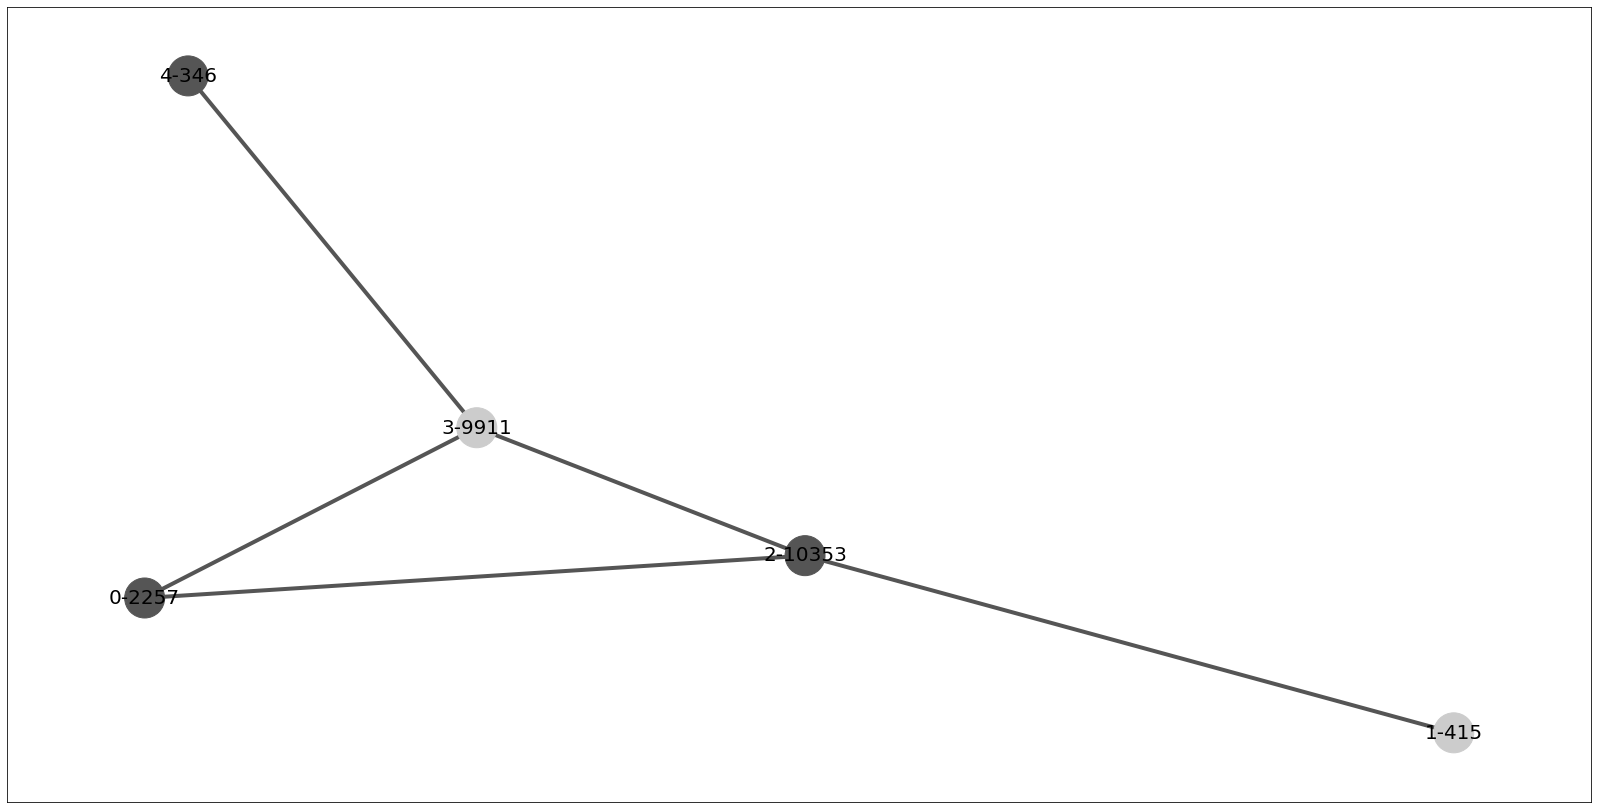

In [41]:
draw(0)
#CAPTION Visualize the solution

In [42]:
(result, cache, draw) = solve_problem_with_qaoa(
    use_network(20),
    maxcut_ev,
    Aer.get_backend('qasm_simulator'),
    precision=10000
)
#CAPTION The weighted Max-Cut problem


Iteration 0
Elapsed time: 0h 0m 19s
{
    "executions": 31,
    "cache_uses": 0,
    "beta": -0.4902137552610733,
    "gamma": 0.32812591052511025
}
Total results: 360603 of 1048576
top-10 performance: ('11011100101101100100', 0.0031, -26.0)
top-50 performance: ('10010110101001100100', 0.0024, -27.0)
top-100 performance: ('01100110010100011011', 0.0023, -28.0)
top-1048576 performance: ('11011000001011100100', 0.0015, -29.0)

Iteration 1
Elapsed time: 0h 0m 12s
{
    "executions": 32,
    "cache_uses": 0,
    "beta": -0.7303639539020951,
    "gamma": 0.4787407571467968
}
Total results: 312459 of 1048576
top-10 performance: ('10111011010100110011', 0.0059, -24.0)
top-50 performance: ('10101111010100011011', 0.0051, -26.0)
top-100 performance: ('10010000101011100100', 0.0049, -27.0)
top-1048576 performance: ('00100111010100011011', 0.0032, -29.0)

Iteration 2
Elapsed time: 0h 0m 11s
{
    "executions": 31,
    "cache_uses": 0,
    "beta": 0.5483236964542743,
    "gamma": 2.53574136588882

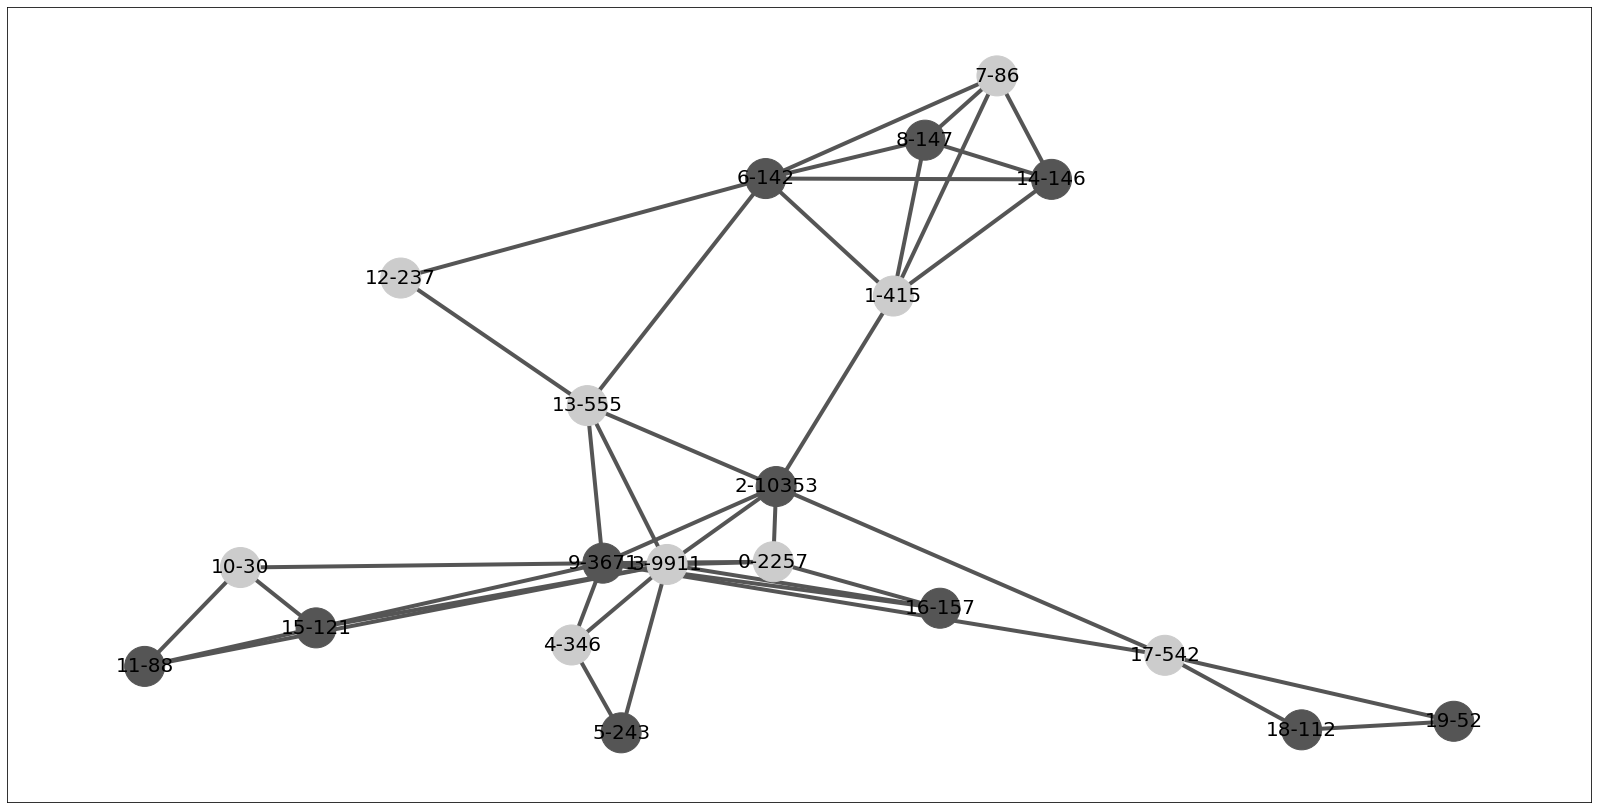

In [43]:
draw(0)
#CAPTION Visualize the solution of the 20-node problem

## Graph Partitioning


In [44]:
from qiskit_optimization.applications import GraphPartition

graph_partition = GraphPartition(use_network(8))

qaoa_optimizer = MinimumEigenOptimizer(QAOA(
    quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator"))
))

result = qaoa_optimizer.solve(
    graph_partition.to_quadratic_program()
)

print("solution:", graph_partition.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)
#CAPTION Solving the graph partitioning problem

solution: [[1, 5, 6, 7], [0, 2, 3, 4]]
time: 22.196370601654053


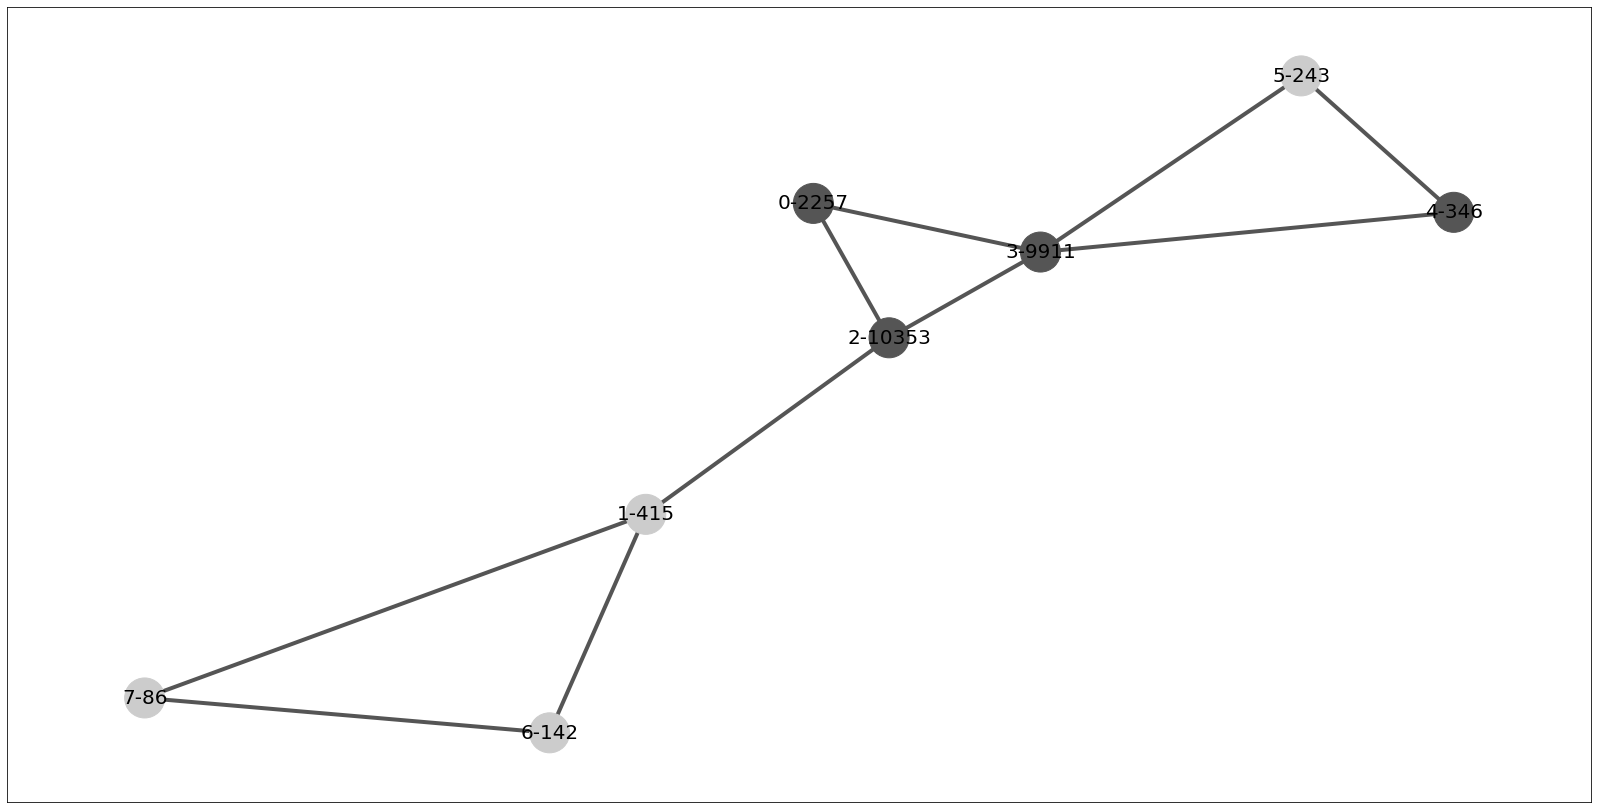

In [45]:
draw_graph(use_network(8),  ''.join(str(int(x)) for x in result.x[::-1]))
#CAPTION Display the solution

In [46]:
qaoa_optimizer = MinimumEigenOptimizer(QAOA(
    quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator")),
    reps=3
))
#CAPTION Specify repititions

In [47]:
result = qaoa_optimizer.solve(
    graph_partition.to_quadratic_program()
)

print("solution:", graph_partition.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)
#CAPTION Solving the graph partitioning problem

solution: [[1, 5, 6, 7], [0, 2, 3, 4]]
time: 63.933385133743286


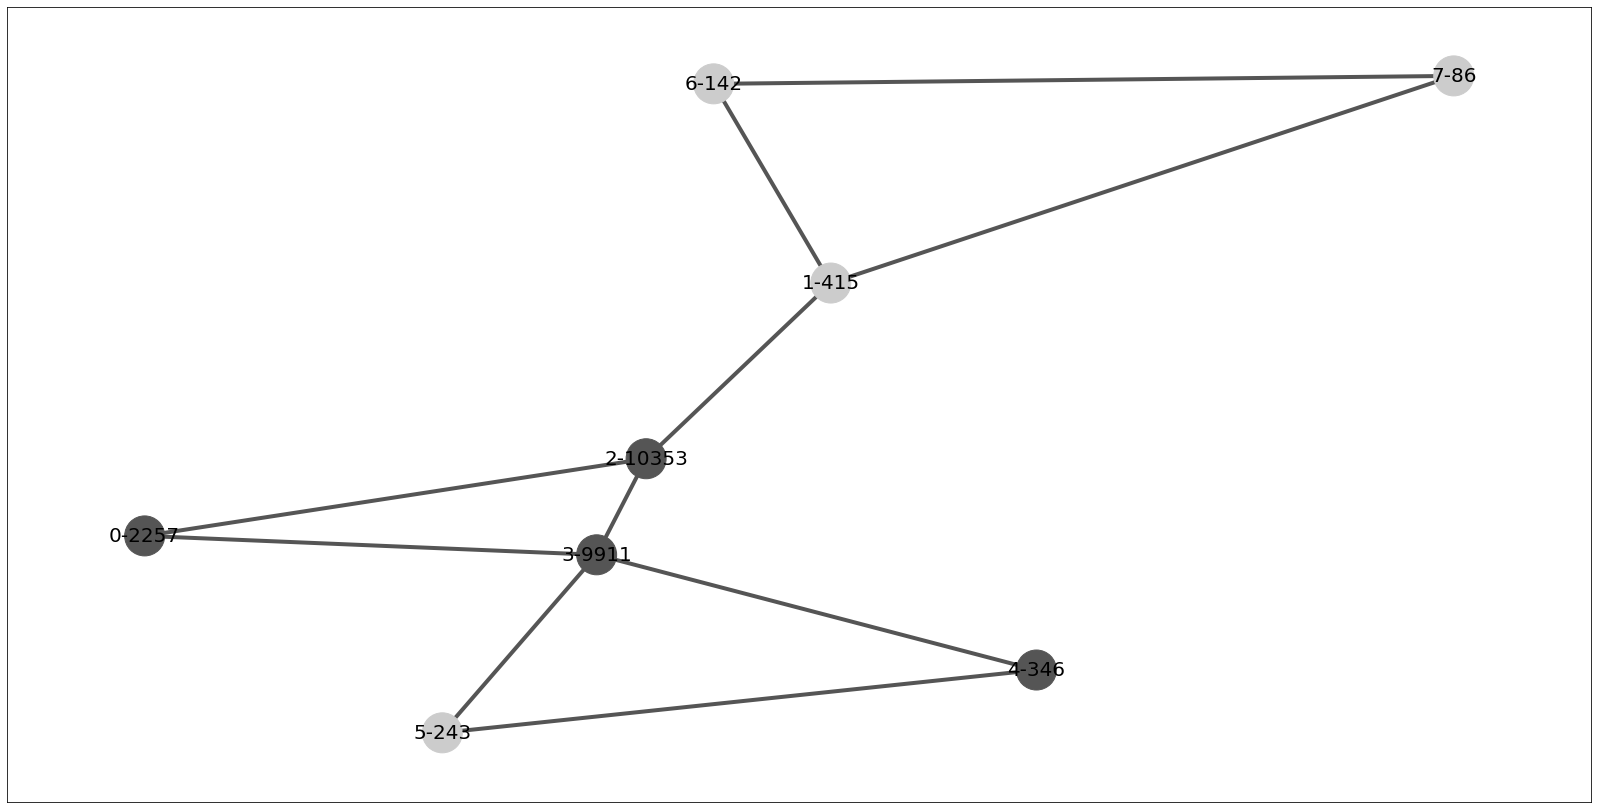

In [48]:
draw_graph(use_network(8),  ''.join(str(int(x)) for x in result.x[::-1]))
#CAPTION Display the solution

In [53]:
class NodeWeightedGraphPartition(GraphPartition):
    def to_quadratic_program(self) -> QuadraticProgram:
        mdl = Model(name="Graph partition")
        n = self._graph.number_of_nodes()
        x = {i: mdl.binary_var(name=f"x_{i}") for i in range(n)}
        for w, v in self._graph.edges:
            self._graph.edges[w, v].setdefault("weight", 1)
        objective = mdl.sum(
            self._graph.edges[i, j]["weight"] * (x[i] + x[j] - 2 * x[i] * x[j])
            for i, j in self._graph.edges
        ) + mdl.sum(
            self._graph.nodes[i]["weight"] * (1-2*x[i])
            for i in self._graph.nodes
        )**2
        mdl.minimize(objective)
        mdl.add_constraint(mdl.sum([x[i] for i in x]) == n // 2)
        op = from_docplex_mp(mdl)
        return op
#CAPTION The extended graph partitioning problem

In [54]:
node_graph_partition = NodeWeightedGraphPartition(use_network(8))

qaoa_optimizer = MinimumEigenOptimizer(QAOA(
    quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator"))
))

result = qaoa_optimizer.solve(
    node_graph_partition.to_quadratic_program()
)

print("solution:", node_graph_partition.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)
#CAPTION Weighted nodes

solution: [[1, 2, 4, 5], [0, 3, 6, 7]]
time: 2.8658950328826904


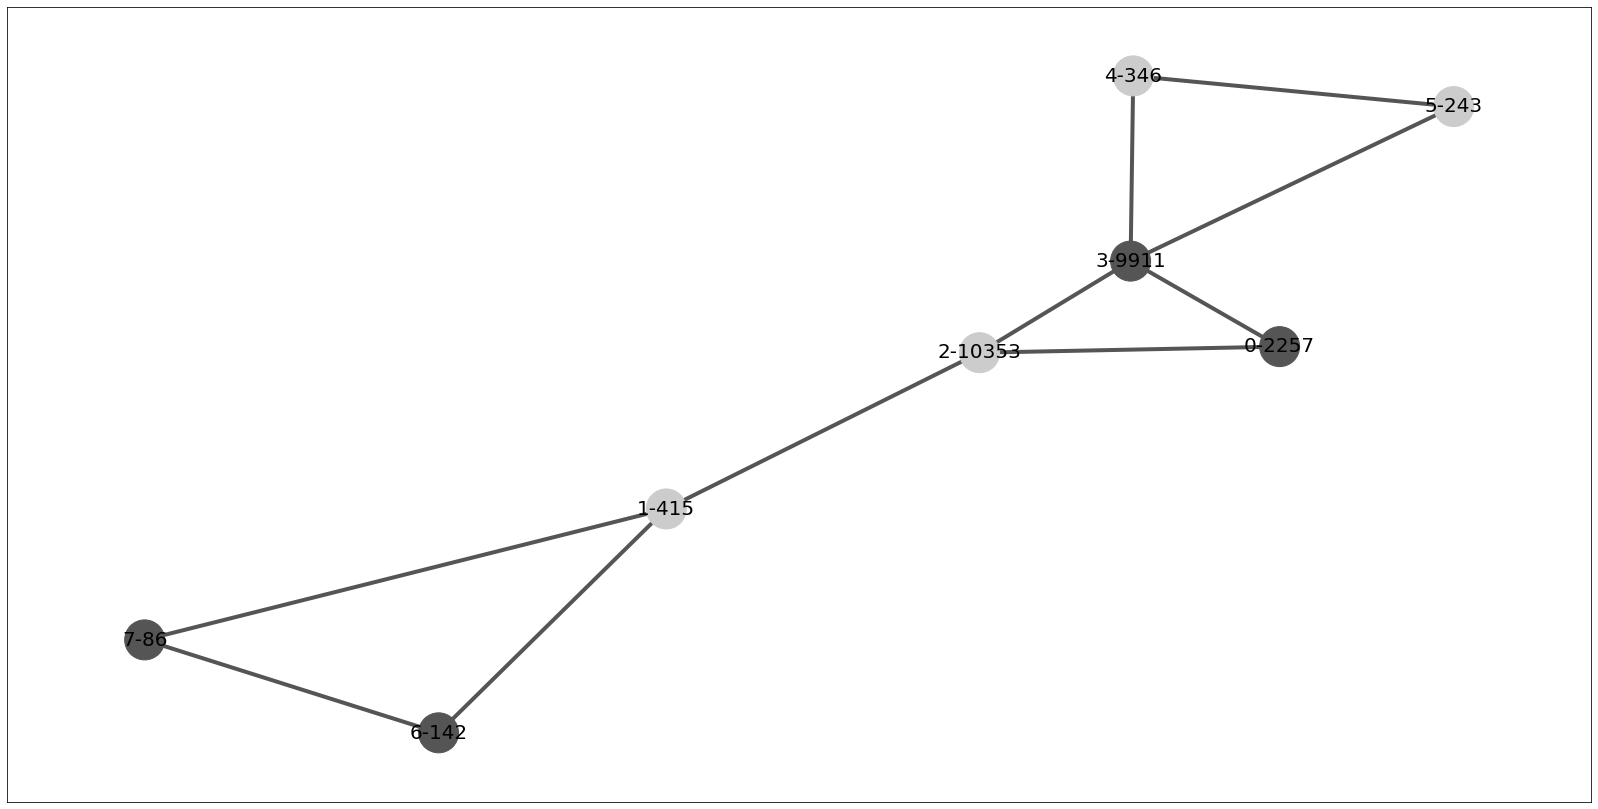

In [55]:
draw_graph(use_network(8),  ''.join(str(int(x)) for x in result.x[::-1]))
#CAPTION Display the solution

In [56]:
def graph_partition_ev(counts, graph):     
    avg = 0
    sum_count = 0
    
    for key, count in counts.items():
        solution = [int(x) for x in key[::-1]]
        eigenvalues = [1-(2*int(x)) for x in solution]
        
        # penalty if the number of elements is not equal
        penalty = len(graph.edges)*sum(eigenvalues[x] for x in graph.nodes)
        
        # count edges that connect nodes from different subsets
        performance = penalty**2 + sum(
            (solution[i] + solution[j] - 2 * solution[i] * solution[j]) for i, j in graph.edges
        )
        
        avg += performance * count
        sum_count += count
    return avg/sum_count
#CAPTION Graph partitioning expectation value

In [57]:
(result, cache, draw) = solve_problem_with_qaoa(
    use_network(8),
    graph_partition_ev,
    Aer.get_backend('qasm_simulator'),
    precision=10,
    repititions=3
)
#CAPTION Solve the graph partition problem


Iteration 0
Elapsed time: 0h 0m 1s
{
    "executions": 28,
    "cache_uses": 0,
    "beta": 1.3304468890264054,
    "gamma": -0.16452576530942417
}
Total results: 252 of 256
top-10 performance: ('10101010', 0.9, 7.0)
top-50 performance: ('10001101', 0.6, 5.0)
top-100 performance: ('00111001', 0.5, 2.0)
top-256 performance: ('00111001', 0.5, 2.0)

Iteration 1
Elapsed time: 0h 0m 1s
{
    "executions": 29,
    "cache_uses": 0,
    "beta": -2.086626066175567,
    "gamma": -0.1793228895479111
}
Total results: 240 of 256
top-10 performance: ('10010110', 0.9, 6.0)
top-50 performance: ('10010110', 0.9, 6.0)
top-100 performance: ('00111100', 0.4, 3.0)
top-256 performance: ('11000110', 0.3, 2.0)

Iteration 2
Elapsed time: 0h 0m 1s
{
    "executions": 26,
    "cache_uses": 0,
    "beta": -0.969155272589106,
    "gamma": -2.5355526301364733
}
Total results: 209 of 256
top-10 performance: ('01001110', 2.0, 6.0)
top-50 performance: ('01001110', 2.0, 6.0)
top-100 performance: ('00111001', 0.4, 2.0)

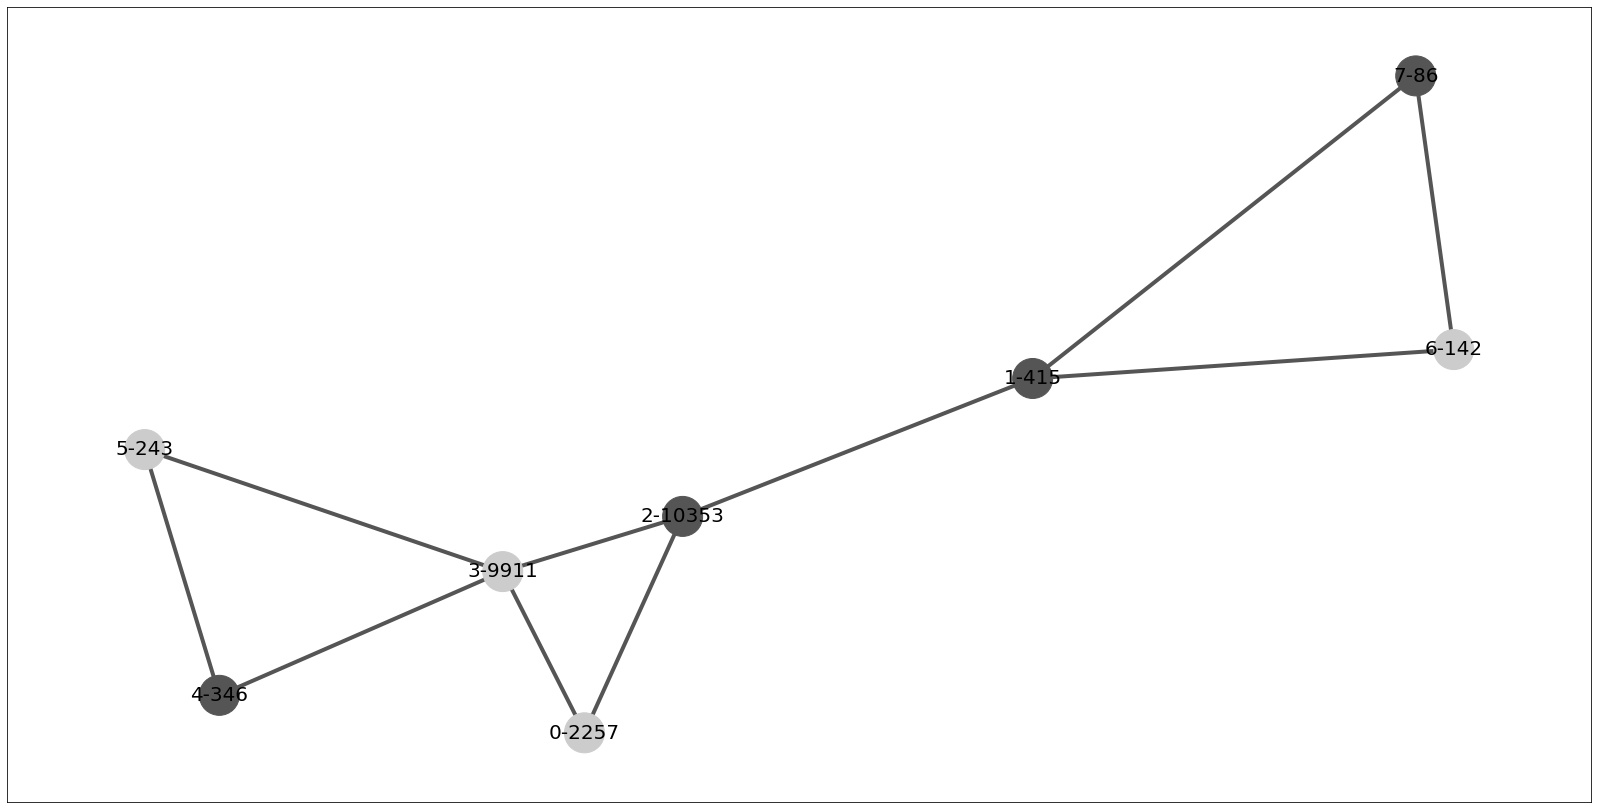

In [58]:
draw(0)
#CAPTION Visualize the top-10 solution

In [59]:
def sol_eigen(key):
    solution = [int(x) for x in key[::-1]]
    eigenvalues = [1-(2*int(x)) for x in solution]
    return (solution, eigenvalues)

In [60]:
def to_perf_gp(key, graph):
    (solution, eigenvalues) = sol_eigen(key)
    
    # penalty if the number of elements is not equal
    penalty = len(graph.edges)*sum(eigenvalues[x] for x in graph.nodes)

    # count edges that connect nodes from different subsets
    performance = penalty**2 + sum(
        (solution[i] + solution[j] - 2 * solution[i] * solution[j]) for i, j in graph.edges
    )
    
    return performance

In [61]:
def biased_ev(to_perf): 
    def _calc(counts, graph):
        perfs = [(
            to_perf(key, graph),
            count
        ) for key, count in counts.items()]

        N = sum(count for p, count in perfs)
        avg = sum(p*count for p, count in perfs)/N
        stdev = math.sqrt(sum((p*count-avg)**2 for p, count in perfs)/N)
        Ns = sum(count**2 for p, count in perfs)
        favor_tops = sum(p*count**2 for p, count in perfs)/Ns

        return favor_tops - N * stdev
    return _calc
#CAPTION Graph partitioning expectation value

In [62]:
(result, cache, draw) = solve_problem_with_qaoa(
    use_network(8),
    biased_ev(to_perf_gp),
    Aer.get_backend('qasm_simulator'),
    precision=10,
    repititions=3
)
#CAPTION Solve the graph partition problem


Iteration 0
Elapsed time: 0h 0m 1s
{
    "executions": 28,
    "cache_uses": 0,
    "beta": -0.9702918284425253,
    "gamma": -0.7217258345085535
}
Total results: 115 of 256
top-10 performance: ('11000010', 7.6, 401.0)
top-50 performance: ('11000110', 2.2, 2.0)
top-100 performance: ('11000110', 2.2, 2.0)
top-256 performance: ('11000110', 2.2, 2.0)

Iteration 1
Elapsed time: 0h 0m 1s
{
    "executions": 32,
    "cache_uses": 0,
    "beta": 1.1306167666814722,
    "gamma": 0.9007313781794283
}
Total results: 95 of 256
top-10 performance: ('11000010', 8.1, 401.0)
top-50 performance: ('00111001', 1.8, 2.0)
top-100 performance: ('00111001', 1.8, 2.0)
top-256 performance: ('00111001', 1.8, 2.0)

Iteration 2
Elapsed time: 0h 0m 1s
{
    "executions": 35,
    "cache_uses": 0,
    "beta": -1.043040880254398,
    "gamma": -0.854651519989484
}
Total results: 108 of 256
top-10 performance: ('11000010', 7.7, 401.0)
top-50 performance: ('00111001', 2.3, 2.0)
top-100 performance: ('00111001', 2.3, 2

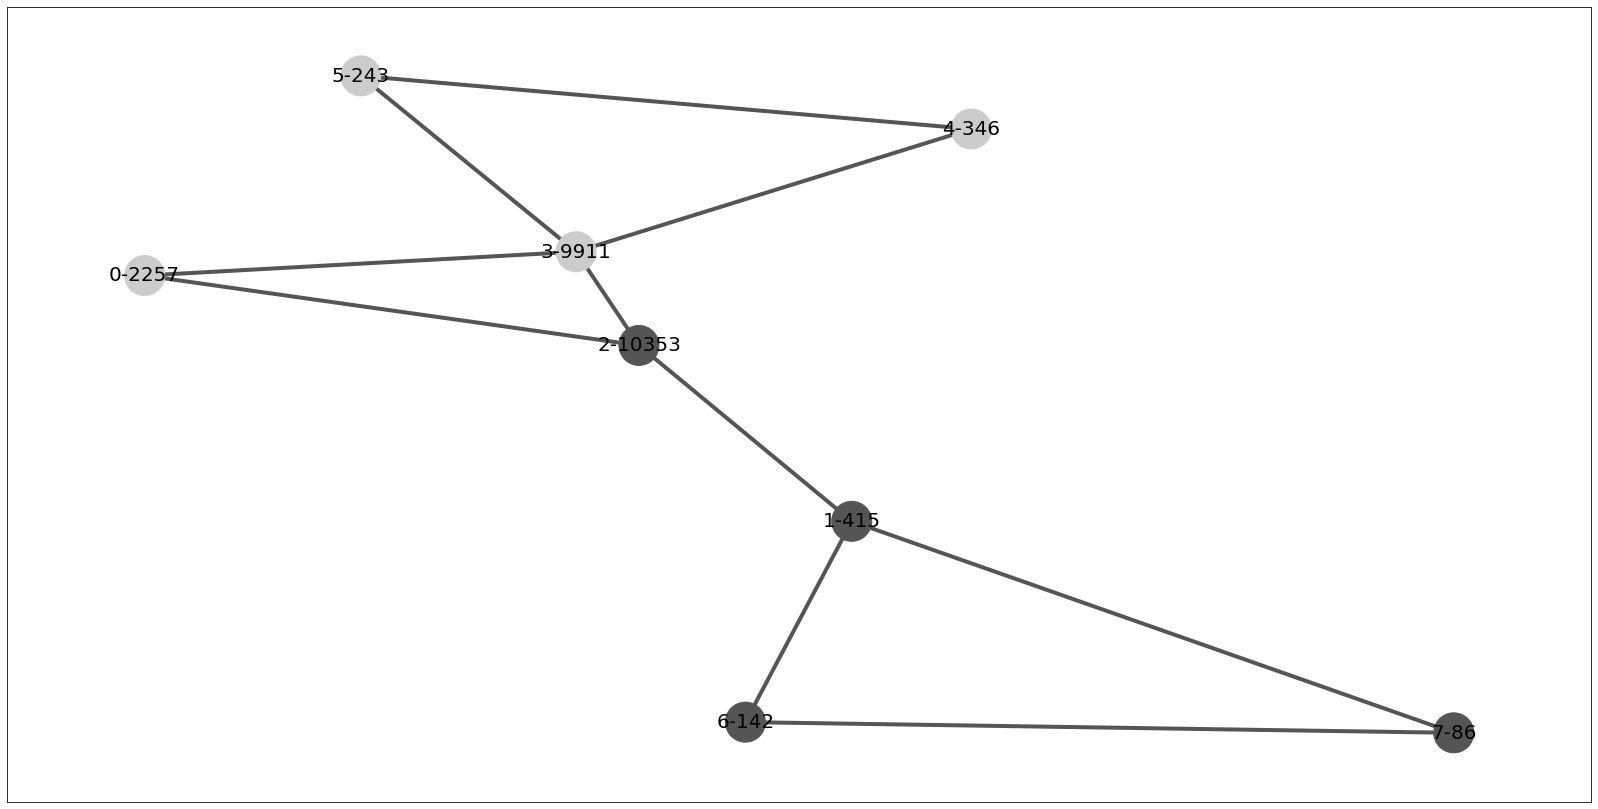

In [63]:
draw(1)
#CAPTION Visualize the solution

In [64]:
def to_perf_wegp(key, graph):
    (solution, eigenvalues) = sol_eigen(key)
    
    # penalty if the number of elements is not equal
    penalty = len(graph.edges)*sum(eigenvalues[x] for x in graph.nodes)

    # count edges that connect nodes from different subsets
    performance = penalty**2 + sum(
        graph.edges[(i,j)]["weight"] * (solution[i] + solution[j] - 2 * solution[i] * solution[j]) for i, j in graph.edges
    )
    
    return performance


(result, cache, draw) = solve_problem_with_qaoa(
    use_network(8),
    biased_ev(to_perf_wegp),
    Aer.get_backend('qasm_simulator'),
    precision=10,
    repititions=3
)
#CAPTION Solve the graph partition problem with weighted edges


Iteration 0
Elapsed time: 0h 0m 0s
{
    "executions": 25,
    "cache_uses": 0,
    "beta": -1.2787623007712179,
    "gamma": 1.8537120641641978
}
Total results: 68 of 256
top-10 performance: ('00110110', 3.3, 63.0)
top-50 performance: ('11110000', 0.3, 18.0)
top-100 performance: ('11110000', 0.3, 18.0)
top-256 performance: ('11110000', 0.3, 18.0)

Iteration 1
Elapsed time: 0h 0m 1s
{
    "executions": 29,
    "cache_uses": 0,
    "beta": 0.9897030134324932,
    "gamma": -2.2117624320800995
}
Total results: 125 of 256
top-10 performance: ('11000010', 4.3, 409.0)
top-50 performance: ('00001111', 0.9, 18.0)
top-100 performance: ('11100010', 0.3, 16.0)
top-256 performance: ('11100010', 0.3, 16.0)

Iteration 2
Elapsed time: 0h 0m 1s
{
    "executions": 30,
    "cache_uses": 0,
    "beta": -0.8881048963218786,
    "gamma": 2.183128634250491
}
Total results: 119 of 256
top-10 performance: ('00111101', 4.7, 409.0)
top-50 performance: ('11110000', 0.8, 18.0)
top-100 performance: ('00011101', 

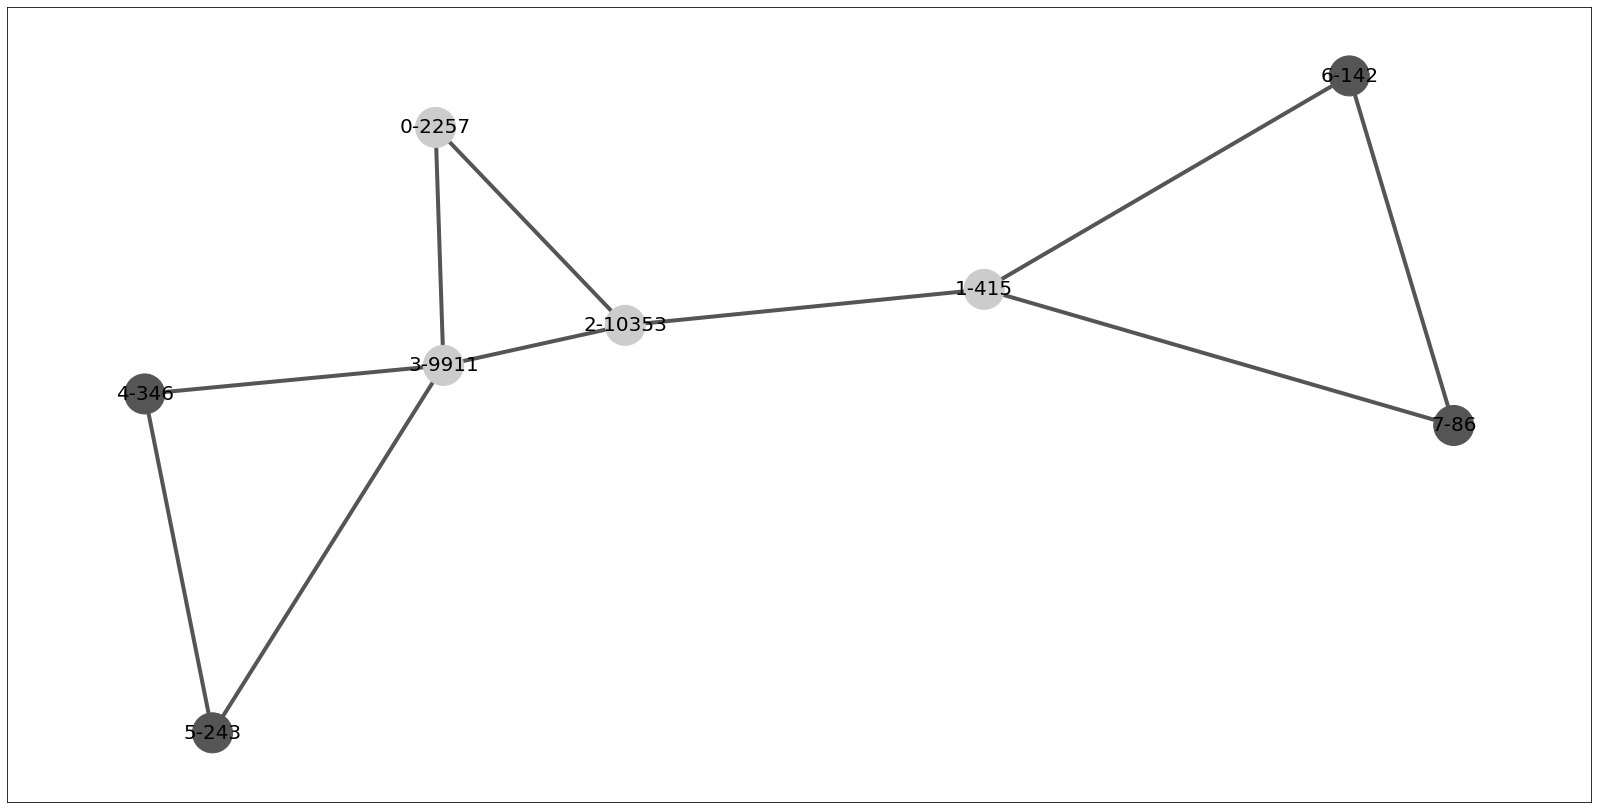

In [65]:
draw(1)
#CAPTION Visualize the weighted edge graph partition

In [66]:
def to_perf_wnwegp(key, graph):
    (solution, eigenvalues) = sol_eigen(key)
    
    # penalty if the number of elements is not equal
    penalty = len(graph.edges)*sum(eigenvalues[x] for x in graph.nodes)

    # count edges that connect nodes from different subsets
    performance = penalty**2 + sum(
        graph.edges[(i,j)]["weight"] * (solution[i] + solution[j] - 2 * solution[i] * solution[j]) for i, j in graph.edges
    ) + sum(
        graph.nodes[i]["weight"]/100 * eigenvalues[i] for i in graph.nodes
    )**2
    
    return performance


(result, cache, draw) = solve_problem_with_qaoa(
    use_network(8),
    biased_ev(to_perf_wnwegp),
    Aer.get_backend('qasm_simulator'),
    precision=10,
    repititions=3
)
#CAPTION Solve the graph partition problem with weighted nodes and edges


Iteration 0
Elapsed time: 0h 0m 1s
{
    "executions": 36,
    "cache_uses": 0,
    "beta": 5.3243611559885045,
    "gamma": -0.8130559631621204
}
Total results: 109 of 256
top-10 performance: ('00111001', 2.4, 355.1121)
top-50 performance: ('00110110', 0.5, 170.95209999999997)
top-100 performance: ('00110110', 0.5, 170.95209999999997)
top-256 performance: ('00110110', 0.5, 170.95209999999997)

Iteration 1
Elapsed time: 0h 0m 1s
{
    "executions": 36,
    "cache_uses": 0,
    "beta": 2.1603652152559616,
    "gamma": -0.9386890989333876
}
Total results: 98 of 256
top-10 performance: ('11000111', 3.5, 1215.9009)
top-50 performance: ('00110110', 0.4, 170.95209999999997)
top-100 performance: ('00110110', 0.4, 170.95209999999997)
top-256 performance: ('00110110', 0.4, 170.95209999999997)

Iteration 2
Elapsed time: 0h 0m 1s
{
    "executions": 29,
    "cache_uses": 0,
    "beta": -1.9537540442714572,
    "gamma": -1.81367575132821
}
Total results: 76 of 256
top-10 performance: ('11001001',

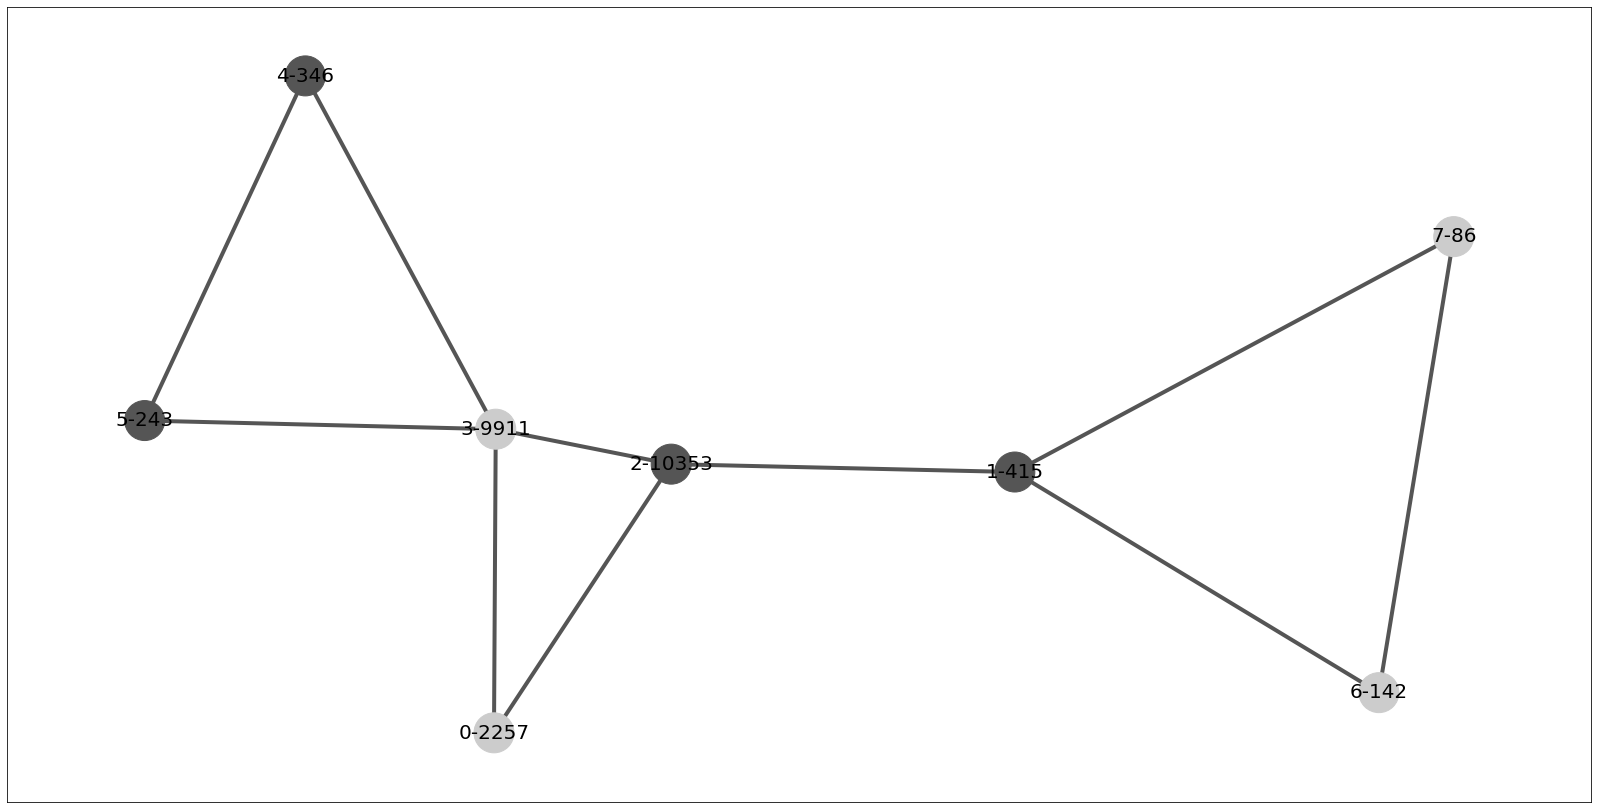

In [67]:
draw(1)
#CAPTION Visualize the weighted nodes and edges solution

In [68]:
(result, cache, draw) = solve_problem_with_qaoa(
    use_network(20),
    biased_ev(to_perf_wnwegp),
    Aer.get_backend('qasm_simulator'),
    precision=10000,
    repititions=3
)


Iteration 0
Elapsed time: 0h 0m 10s
{
    "executions": 28,
    "cache_uses": 0,
    "beta": 1.8613354883773312,
    "gamma": -0.5583128881775041
}
Total results: 235134 of 1048576
top-10 performance: ('00000101000111000010', 0.1514, 187249.02250000002)
top-50 performance: ('00011000111000111001', 0.0782, 8747.7369)
top-100 performance: ('00011000111000111001', 0.0782, 8747.7369)
top-1048576 performance: ('00011001111010111000', 0.0005, 108.8561)

Iteration 1
Elapsed time: 0h 0m 13s
{
    "executions": 29,
    "cache_uses": 0,
    "beta": 1.6809817829338165,
    "gamma": -0.5474929149794984
}
Total results: 290802 of 1048576
top-10 performance: ('11111010111000111101', 0.0725, 187249.02250000002)
top-50 performance: ('00011000111000111001', 0.0298, 8747.7369)
top-100 performance: ('00011010111000110101', 0.0248, 3848.2961000000005)
top-1048576 performance: ('11100110000101000111', 0.0012, 108.8561)

Iteration 2
Elapsed time: 0h 0m 11s
{
    "executions": 30,
    "cache_uses": 0,
    "

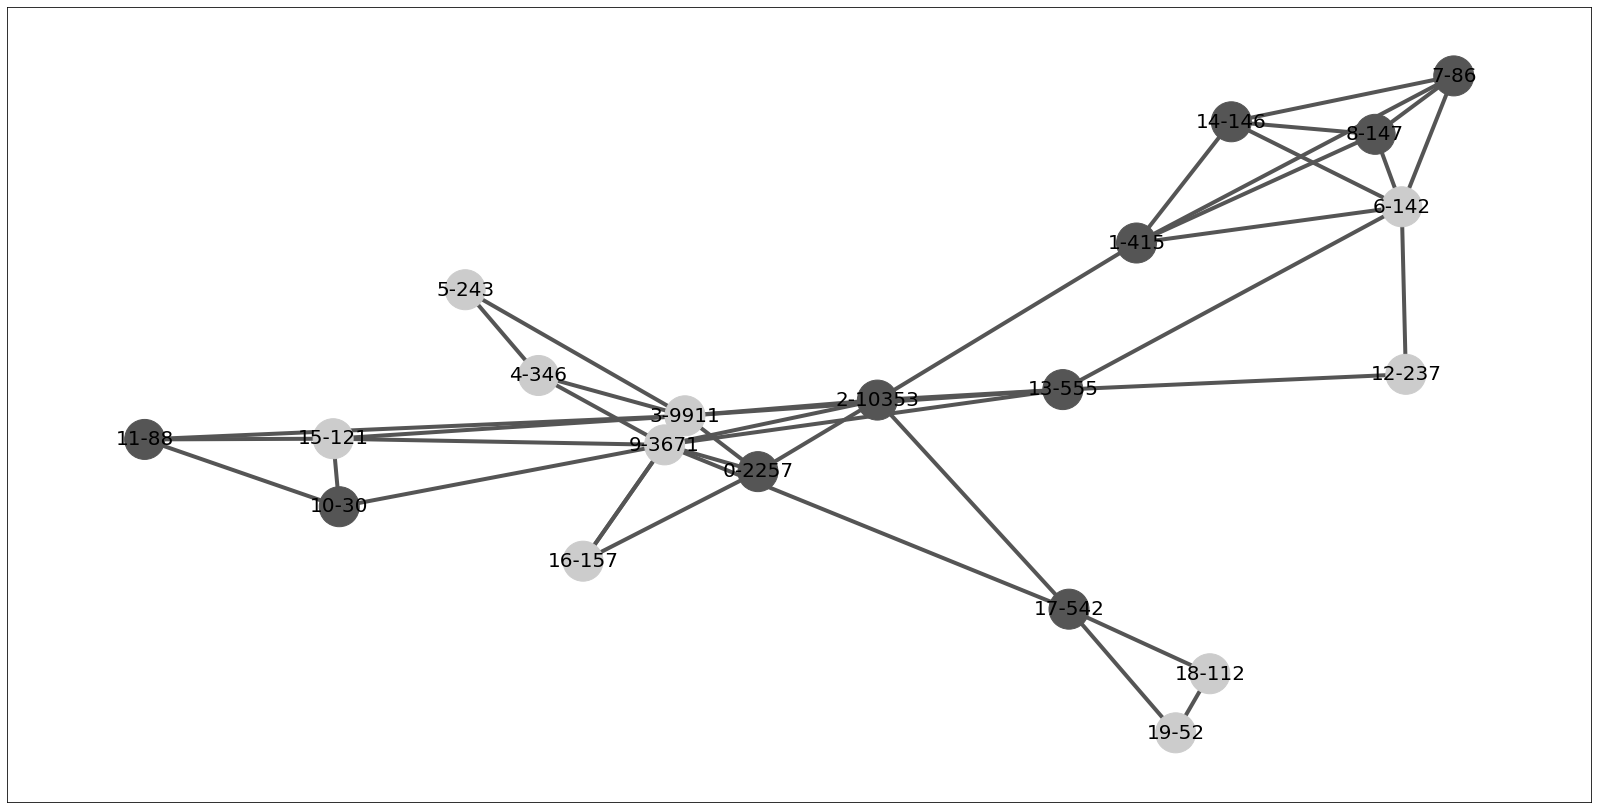

In [69]:
draw(2)
#CAPTION Visualize the top-100 solution with 20 nodes

## Cliques


In [70]:
from qiskit_optimization.applications.clique import Clique

clique = Clique(use_network(8))

qaoa_optimizer = MinimumEigenOptimizer(QAOA(
    quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator")),
    reps=3
))

result = qaoa_optimizer.solve(
    clique.to_quadratic_program()
)
print("solution:", clique.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)
#CAPTION Solving the clique problem with Qiskit

solution: [0, 2, 3]
time: 60.95511770248413


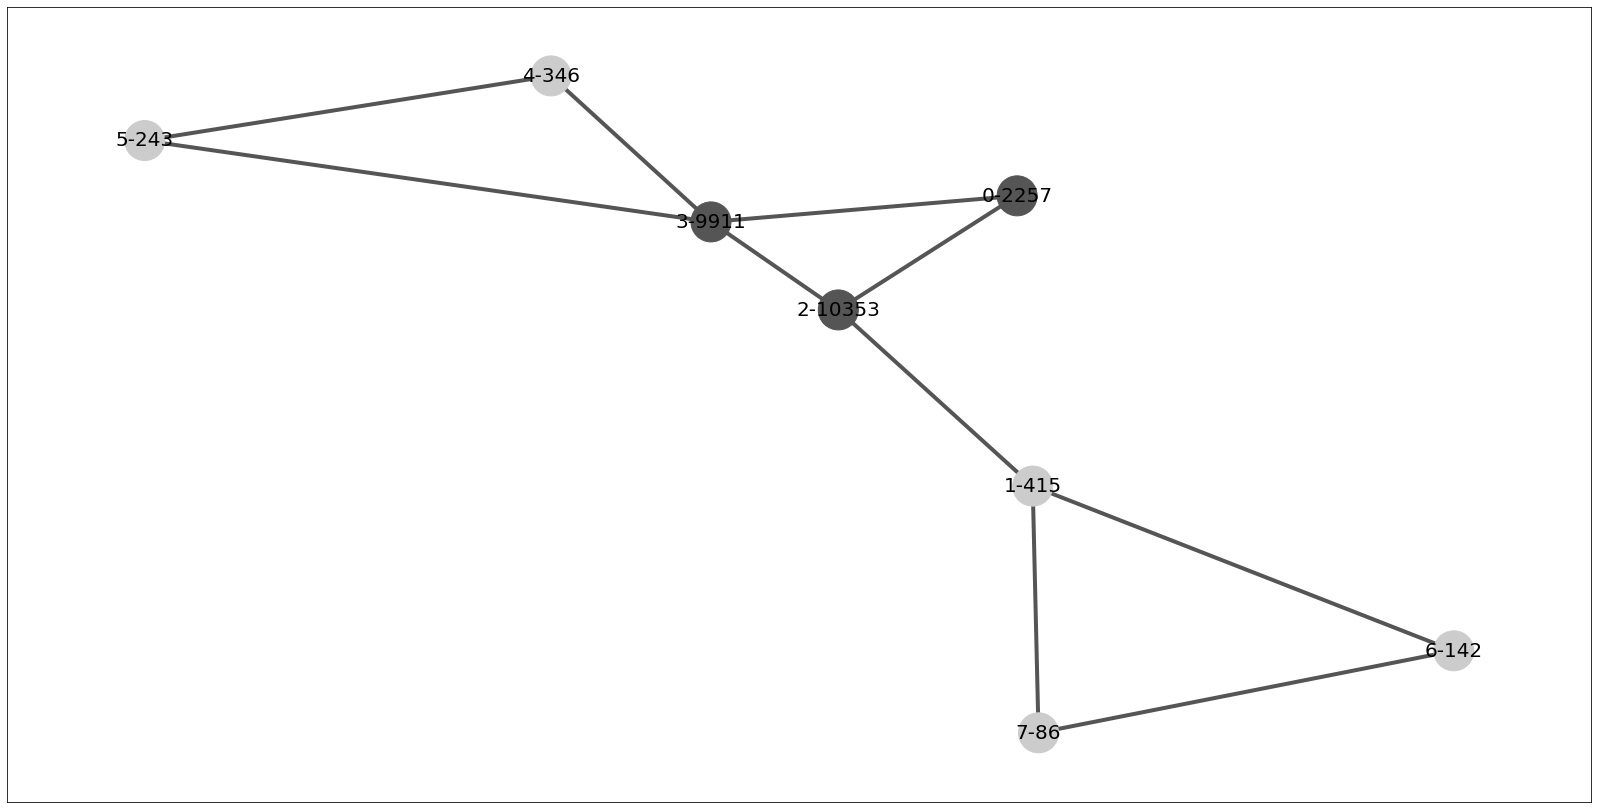

In [71]:
draw_graph(use_network(8),  ''.join(str(int(x)) for x in result.x[::-1]))
#CAPTION Display the clique solution

In [72]:
def to_perf_cliques(key, graph):
    (solution, eigenvalues) = sol_eigen(key)
    
    # the bigger the clique, the better
    clique_size = sum(int(solution[node]) for node in graph.nodes)

    # the number of connections a clique of the solution size 
    # would need to have
    required_edges = (clique_size)*(clique_size-1)/2

    # count the connections of the clique
    clique_edges = sum(int(solution[i])*int(solution[j]) for i, j in graph.edges)

    performance = clique_size**2*(min(3,(required_edges-clique_edges))-1)
    
    return performance


(result, cache, draw) = solve_problem_with_qaoa(
    use_network(8),
    biased_ev(to_perf_cliques),
    Aer.get_backend('qasm_simulator'),
    precision=10,
    repititions=3
)
#CAPTION Solve the clique problem


Iteration 0
Elapsed time: 0h 0m 1s
{
    "executions": 25,
    "cache_uses": 0,
    "beta": 4.029338804492826,
    "gamma": 0.818026232008223
}
Total results: 114 of 256
top-10 performance: ('11000010', 7.5, -9.0)
top-50 performance: ('11000010', 7.5, -9.0)
top-100 performance: ('11000010', 7.5, -9.0)
top-256 performance: ('11000010', 7.5, -9.0)

Iteration 1
Elapsed time: 0h 0m 1s
{
    "executions": 34,
    "cache_uses": 0,
    "beta": 4.512758737119851,
    "gamma": -1.7554917261311558
}
Total results: 52 of 256
top-10 performance: ('00000011', 4.1, 0.0)
top-50 performance: ('00001101', 2.9, -9.0)
top-100 performance: ('00001101', 2.9, -9.0)
top-256 performance: ('00001101', 2.9, -9.0)

Iteration 2
Elapsed time: 0h 0m 1s
{
    "executions": 30,
    "cache_uses": 0,
    "beta": 1.9278052738794644,
    "gamma": -1.209469213664341
}
Total results: 65 of 256
top-10 performance: ('11000010', 6.8, -9.0)
top-50 performance: ('11000010', 6.8, -9.0)
top-100 performance: ('11000010', 6.8, -9.

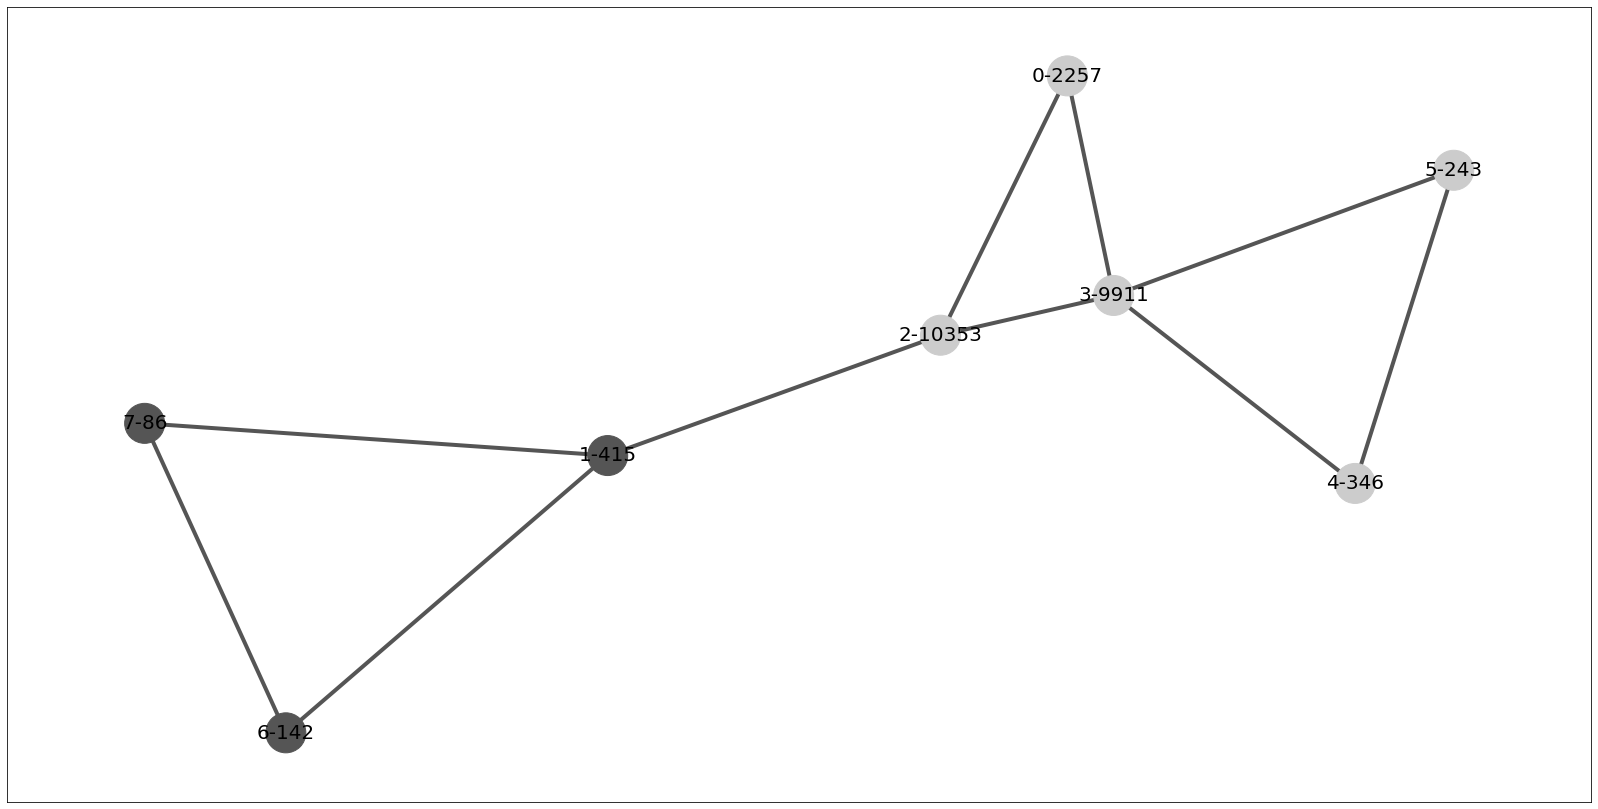

In [73]:
draw(0)
#CAPTION Visualize the top-10 solution with 8 nodes

In [74]:
(result, cache, draw) = solve_problem_with_qaoa(
    use_network(20),
    biased_ev(to_perf_cliques),
    Aer.get_backend('qasm_simulator'),
    precision=10,
    repititions=3
)
#CAPTION Solve the clique problem with 20 nodes


Iteration 0
Elapsed time: 0h 0m 10s
{
    "executions": 31,
    "cache_uses": 0,
    "beta": -1.8466807417639215,
    "gamma": 0.6716846221421843
}
Total results: 948 of 1048576
top-10 performance: ('11100000000000000000', 0.3, -9.0)
top-50 performance: ('11100000000000000000', 0.3, -9.0)
top-100 performance: ('11100000000000000000', 0.3, -9.0)
top-1048576 performance: ('00000010001000001100', 0.1, -16.0)

Iteration 1
Elapsed time: 0h 0m 13s
{
    "executions": 33,
    "cache_uses": 0,
    "beta": -1.0500977836728353,
    "gamma": -0.44976793817113797
}
Total results: 967 of 1048576
top-10 performance: ('00000000000000000000', 0.5, 0.0)
top-50 performance: ('00000011000000000000', 0.1, -4.0)
top-100 performance: ('00000011000000000000', 0.1, -4.0)
top-1048576 performance: ('00000100000110000010', 0.1, -16.0)

Iteration 2
Elapsed time: 0h 0m 13s
{
    "executions": 29,
    "cache_uses": 0,
    "beta": -0.49556228238997435,
    "gamma": 2.3186517676843743
}
Total results: 998 of 1048576

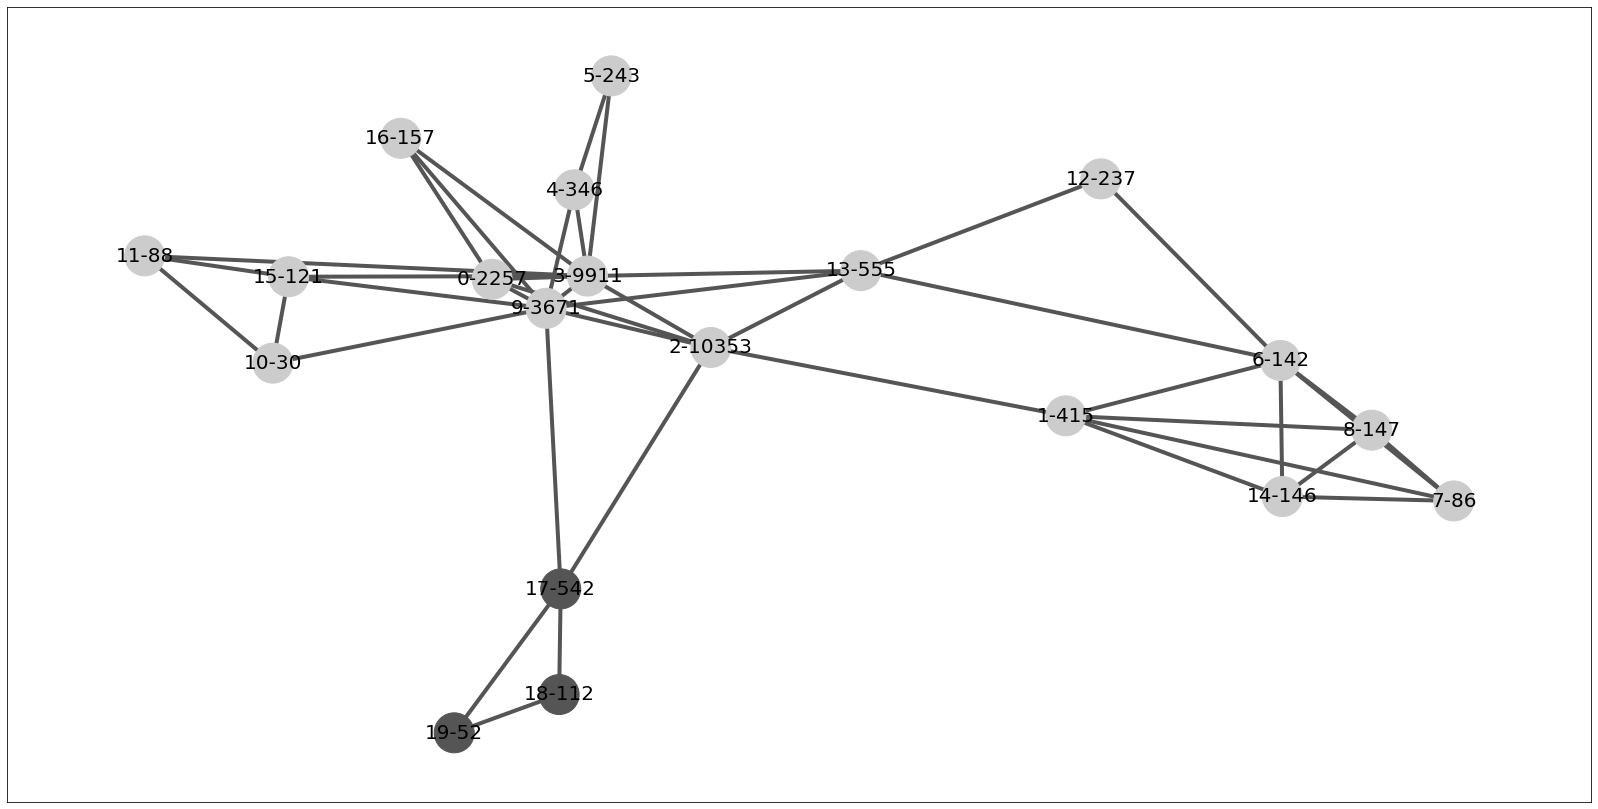

In [75]:
draw(0)
#CAPTION Visualize the result of the 20-node clique

In [76]:
CLIQUE_SIZE = 5
REQUIRED_EDGES = (CLIQUE_SIZE)*(CLIQUE_SIZE-1)/2

def to_perf_fixcliques(key, graph):
    (solution, eigenvalues) = sol_eigen(key)
    
    clique_size = sum(int(solution[node]) for node in graph.nodes)
            
    # count the connections of the clique
    clique_edges = sum(int(solution[i])*int(solution[j]) for i, j in graph.edges)

    performance = (clique_size-CLIQUE_SIZE)**2 + (REQUIRED_EDGES-clique_edges)**2  
    return performance


(result, cache, draw) = solve_problem_with_qaoa(
    use_network(20),
    biased_ev(to_perf_fixcliques),
    Aer.get_backend('qasm_simulator'),
    precision=10,
    repititions=3
)
#CAPTION Solve the clique problem with a fixed size


Iteration 0
Elapsed time: 0h 0m 14s
{
    "executions": 36,
    "cache_uses": 0,
    "beta": 5.3209693408237655,
    "gamma": -0.6263874103946241
}
Total results: 935 of 1048576
top-10 performance: ('00000101001111000010', 0.2, 5.0)
top-50 performance: ('00000100000111000010', 0.2, 0.0)
top-100 performance: ('00000100000111000010', 0.2, 0.0)
top-1048576 performance: ('00000100000111000010', 0.2, 0.0)

Iteration 1
Elapsed time: 0h 0m 14s
{
    "executions": 37,
    "cache_uses": 0,
    "beta": 1.6238723021283288,
    "gamma": 0.48233748260348125
}
Total results: 994 of 1048576
top-10 performance: ('01001111000110000010', 0.2, 18.0)
top-50 performance: ('00000100000111100010', 0.1, 1.0)
top-100 performance: ('00000100000111000010', 0.1, 0.0)
top-1048576 performance: ('00000100000111000010', 0.1, 0.0)

Iteration 2
Elapsed time: 0h 0m 9s
{
    "executions": 28,
    "cache_uses": 0,
    "beta": 2.4908517785964626,
    "gamma": 2.56385625168656
}
Total results: 996 of 1048576
top-10 perform

In [77]:
CLIQUE_SIZE = 6
REQUIRED_EDGES = (CLIQUE_SIZE)*(CLIQUE_SIZE-1)/2


def to_perf_fixcliques(key, graph):
    (solution, eigenvalues) = sol_eigen(key)
    
    clique_size = sum(int(solution[node]) for node in graph.nodes)
            
    # count the connections of the clique
    clique_edges = sum(int(solution[i])*int(solution[j]) for i, j in graph.edges)

    performance = (clique_size-CLIQUE_SIZE)**2 + (REQUIRED_EDGES-clique_edges)**2
    
    return performance

(result, cache, draw) = solve_problem_with_qaoa(
    use_network(20),
    biased_ev(to_perf_fixcliques),
    Aer.get_backend('qasm_simulator'),
    precision=10,
    repititions=3
)
#CAPTION Solve the clique problem with a fixed size


Iteration 0
Elapsed time: 0h 0m 9s
{
    "executions": 27,
    "cache_uses": 0,
    "beta": 1.0498238256185628,
    "gamma": 0.5308380296990944
}
Total results: 934 of 1048576
top-10 performance: ('00000111000111100010', 0.3, 8.0)
top-50 performance: ('00011000101000111001', 0.2, 5.0)
top-100 performance: ('00011000101000111001', 0.2, 5.0)
top-1048576 performance: ('00101010111000001100', 0.1, 4.0)

Iteration 1
Elapsed time: 0h 0m 12s
{
    "executions": 34,
    "cache_uses": 0,
    "beta": 2.446072163586822,
    "gamma": -0.5933615171049759
}
Total results: 968 of 1048576
top-10 performance: ('00001100110111000010', 0.2, 8.0)
top-50 performance: ('00001100110111000010', 0.2, 8.0)
top-100 performance: ('00001100110111000010', 0.2, 8.0)
top-1048576 performance: ('00110000001000111101', 0.1, 4.0)

Iteration 2
Elapsed time: 0h 0m 8s
{
    "executions": 30,
    "cache_uses": 0,
    "beta": 1.8920824530480542,
    "gamma": -0.5510318104903993
}
Total results: 958 of 1048576
top-10 performa

## Stable Set



In [78]:
from qiskit_optimization.applications import StableSet
stable_set = StableSet(use_network(20))

qaoa_optimizer = MinimumEigenOptimizer(QAOA(
    quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator")),
    reps=3
))

result = qaoa_optimizer.solve(
    stable_set.to_quadratic_program()
)
print("solution:", stable_set.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)
#CAPTION Solving the stable set problem

solution: [2, 4, 6, 15, 18]
time: 1287.4683651924133


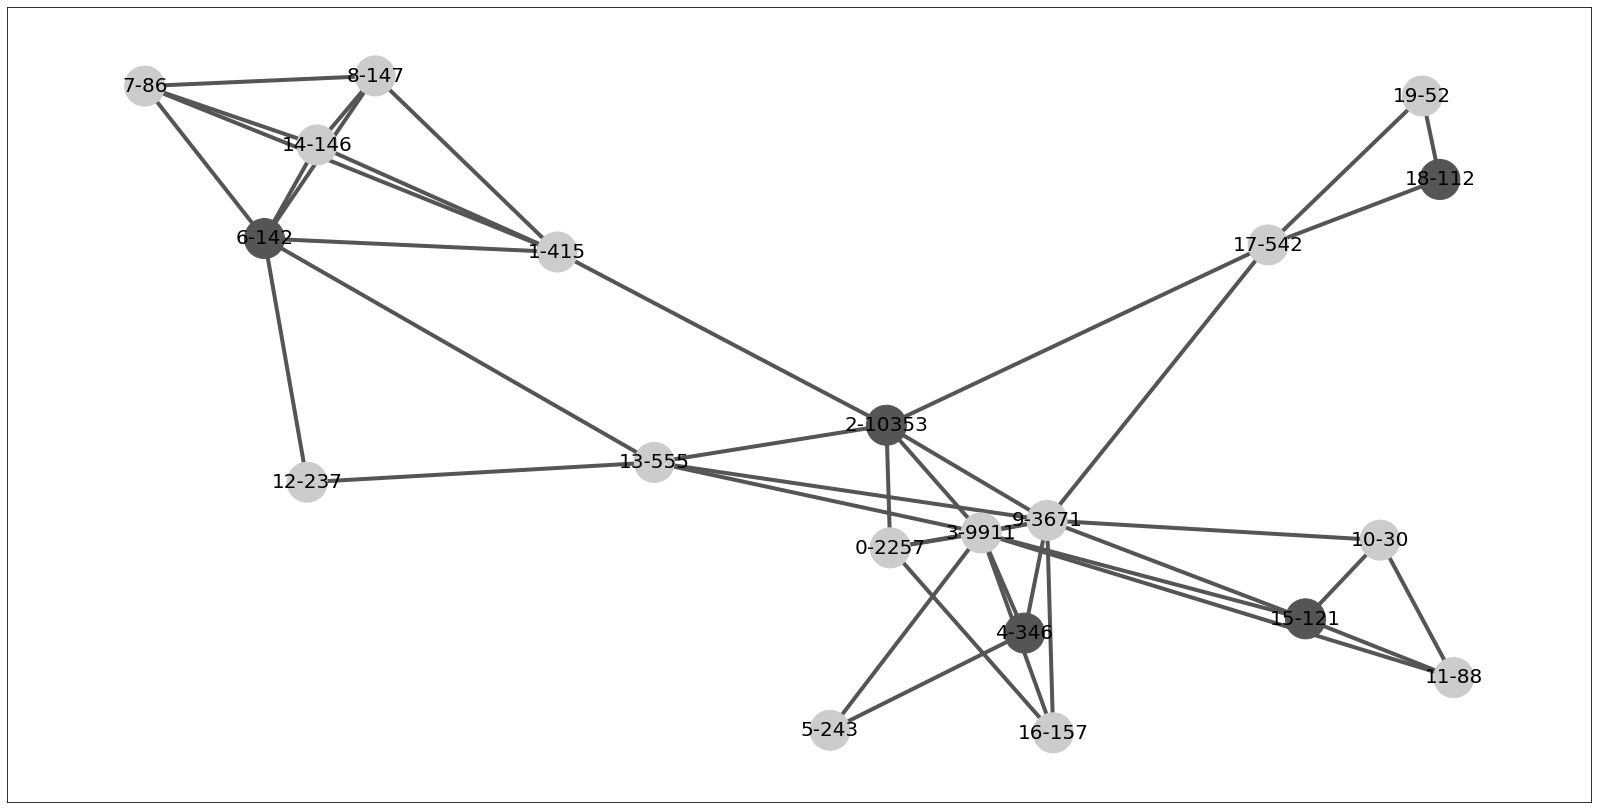

In [79]:
draw_graph(use_network(20),  ''.join(str(int(x)) for x in result.x[::-1]))
#CAPTION Display the solution

In [80]:
def to_perf_stableset(key, graph):
    (solution, eigenvalues) = sol_eigen(key)
    
    # the more nodes there are, the better
    size = sum(int(solution[node]) for node in graph.nodes)

    # count the connections of the clique
    adjacent_edges = sum(int(solution[edge[0]])*int(solution[edge[1]]) for edge in graph.edges)

    performance = (len(graph.nodes)*adjacent_edges)**2 - size
    
    return performance


(result, cache, draw) = solve_problem_with_qaoa(
    use_network(20),
    biased_ev(to_perf_stableset),
    Aer.get_backend('qasm_simulator'),
    precision=1000,
    repititions=3
)
#CAPTION Solve the stable-set problem


Iteration 0
Elapsed time: 0h 0m 13s
{
    "executions": 38,
    "cache_uses": 0,
    "beta": -1.9083244087883977,
    "gamma": 0.5521090809995209
}
Total results: 51956 of 1048576
top-10 performance: ('00000000000000000000', 0.291, 0.0)
top-50 performance: ('00000001000000000000', 0.119, -1.0)
top-100 performance: ('00000001000000100000', 0.05, -2.0)
top-1048576 performance: ('00010001100100100100', 0.001, -6.0)

Iteration 1
Elapsed time: 0h 0m 8s
{
    "executions": 28,
    "cache_uses": 0,
    "beta": -1.014172786984111,
    "gamma": -0.45912614229321036
}
Total results: 49746 of 1048576
top-10 performance: ('00000000000000000000', 0.311, 0.0)
top-50 performance: ('00000001000000000000', 0.117, -1.0)
top-100 performance: ('00000001000000100000', 0.048, -2.0)
top-1048576 performance: ('10010101000000010100', 0.001, -6.0)

Iteration 2
Elapsed time: 0h 0m 13s
{
    "executions": 37,
    "cache_uses": 0,
    "beta": 2.059754621310897,
    "gamma": -0.5149191053836508
}
Total results: 47

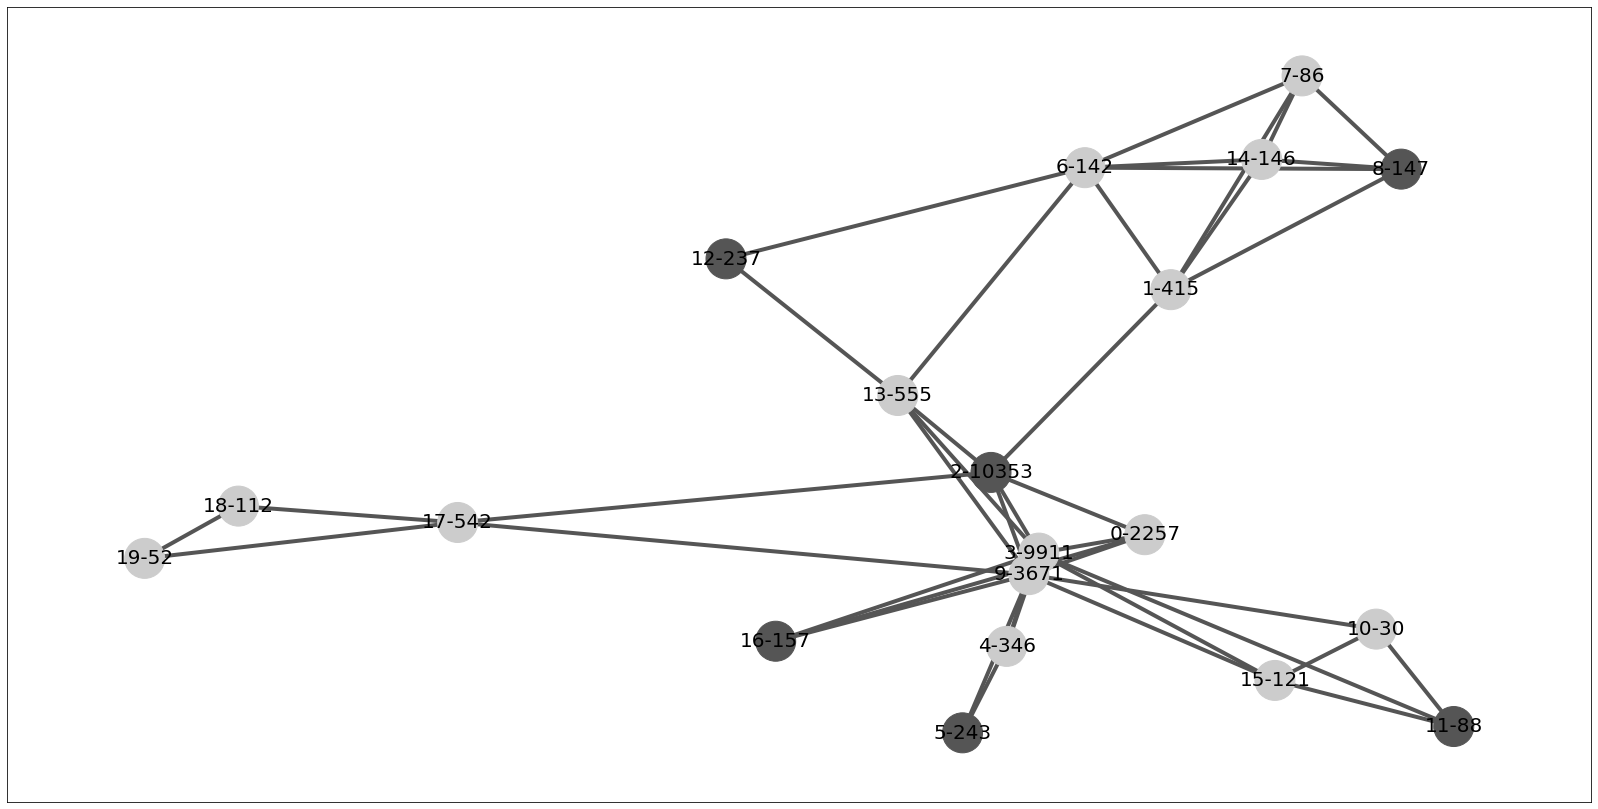

In [81]:
draw(3)
#CAPTION Visualuze the result of the stable-set

## Traveling Salesman

In [82]:
def select_tsp_heroes(size):
     return dict(item for cnt, item in enumerate({
        'CAPTAIN AMERICA': 0,
        'SPIDER-MAN/PETER PAR': 1,
        'IRON MAN/TONY STARK ': 2,
        'THOR/DR. DONALD BLAK': 3,
        'THING/BENJAMIN J. GR': 4,
        'WOLVERINE/LOGAN ': 5,
        'HUMAN TORCH/JOHNNY S': 6,
        'SCARLET WITCH/WANDA ': 7,
        'MR. FANTASTIC/REED R': 8,
        "VISION ": 9,
        'INVISIBLE WOMAN/SUE ': 10,
        'BEAST/HENRY &HANK& P': 11
    }.items()) if cnt < size)
#CAPTION Select a fully connected subset of heroes

In [83]:
def use_network(size, select_heroes=select_heroes):
    data = pd.read_csv('./data/hero-network.csv')
    heroes = select_heroes(size)
    
    # filter the relations from the raw data
    relations = data[(data.hero1.isin(heroes.keys())) & (data.hero2.isin(heroes.keys()))]
    relations = pd.DataFrame(np.sort(relations.values, axis=1), columns=relations.columns)

    # build unique relations with counts
    relations['relation'] = [' - '.join(x) for x in np.sort(relations.to_numpy(), axis=1)]    
    summed_relations = relations.groupby(['relation']).size().reset_index().rename(columns={0:'count'})
    summed_relations = pd.merge(summed_relations, relations, on='relation', how='right').drop_duplicates(subset=['hero1', 'hero2'])
    summed_relations.drop(summed_relations[summed_relations['hero1'] == summed_relations['hero2']].index, inplace = True)
    
    # count the overall appearences of the heroes
    count_series1 = data.groupby(['hero1']).size()
    count_series2 = data.groupby(['hero2']).size()
    appearences = count_series1.add(count_series2, fill_value=0)

    # create the graph
    graph = nx.Graph()
    graph.add_nodes_from(heroes.values())
    graph.add_edges_from([(
            heroes[rel[1][2]],
            heroes[rel[1][3]]
        ) for rel in summed_relations.iterrows()])
    
    

    # add node weight
    for hero in heroes:
        graph.nodes[heroes[hero]]["weight"] = appearences[hero]
        graph.nodes[heroes[hero]]["name"] = hero
    
    # add edge weights
    edge_weights = dict((
            (heroes[rel[1][2]], heroes[rel[1][3]]),
            rel[1][1]
        ) for rel in summed_relations.iterrows())
    # named weight!
    nx.set_edge_attributes(graph, edge_weights, "weight")
    
    return graph
#CAPTION Create the network graph

In [84]:
from qiskit_optimization.applications import Tsp
tsp = Tsp(use_network(4, select_tsp_heroes))

qaoa_optimizer = MinimumEigenOptimizer(QAOA(
    quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator")),
    reps=3
))

result = qaoa_optimizer.solve(
    tsp.to_quadratic_program()
)
print("solution:", tsp.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)
#CAPTION Solving the traveling salesman problem

solution: [[], 3, [], 1]
time: 828.5139925479889


In [85]:
result.status
#CAPTION Look at the result status

<OptimizationResultStatus.INFEASIBLE: 2>

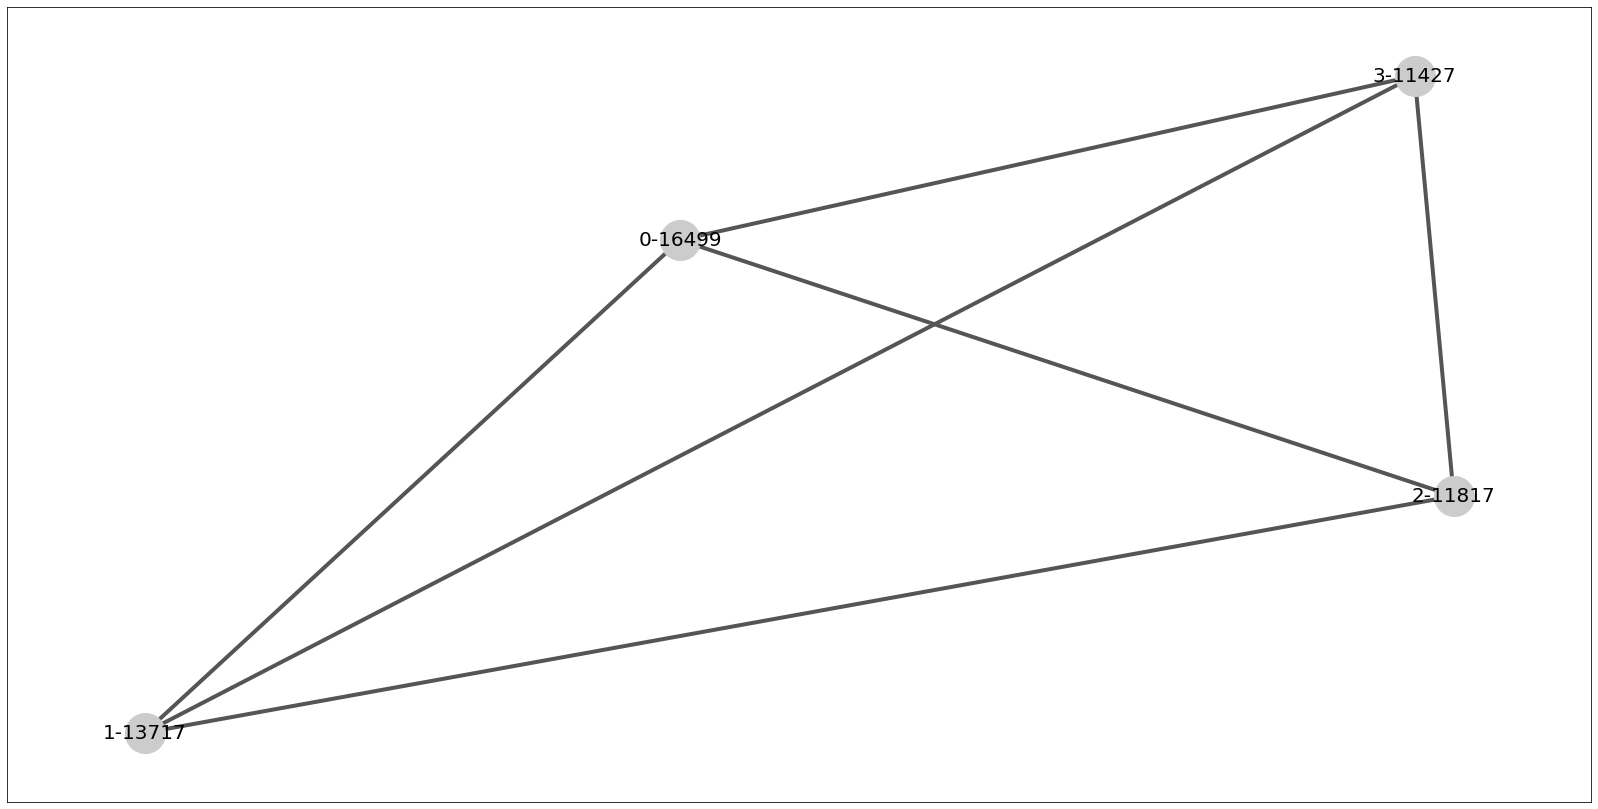

In [86]:
draw_graph(use_network(4, select_tsp_heroes))
#CAPTION Visualize four heroes

In [87]:
def problem_circuit(graph, gamma):
    nodes = len(graph.nodes())
    qc_p = QuantumCircuit(nodes**2)
    
    for cycle in range(nodes):
        for edge in list(graph.edges()):
            qc_p.rzz(gamma, (cycle*nodes)+edge[0], ((cycle+1 if cycle < nodes-1 else 0)*nodes)+edge[1])
            qc_p.rzz(gamma, (cycle*nodes)+edge[1], ((cycle+1 if cycle < nodes-1 else 0)*nodes)+edge[0])
            
    return qc_p


def ansatz_circuit(graph, beta):
    qc_a = QuantumCircuit(len(graph.nodes())**2)
    for i in range(len(graph.nodes())**2):
        qc_a.rx(beta, i)
    
    return qc_a


def get_circuit(graph, beta, gamma):
    cnt_qubits = len(graph.nodes())**2
    qc_qaoa = QuantumCircuit(cnt_qubits)

    # initial_state
    qc_qaoa.h(range(cnt_qubits))
    
    # append problem circuit
    qc_qaoa.append(problem_circuit(graph, gamma), range(cnt_qubits))
    
    # append ansatz circuit
    qc_qaoa.append(ansatz_circuit(graph, beta), range(cnt_qubits))

    qc_qaoa.measure_all()
    return qc_qaoa
#CAPTION Changed functions

In [88]:
def solve(
    result,
    graph,
    calc_expectation_value, # added
    backend,
    show_top=0,
    topcnt=[10],
    precision=100000
):
    
    qc_res = get_circuit(graph, result.x[0], result.x[1])
    counts = execute(qc_res, backend, shots=100*precision).result().get_counts()
    ordered = list(reversed(sorted(counts.items(), key=lambda item: item[1])))[:max(topcnt)]
    
    evaluated = [(k, v/precision, calc_expectation_value({k: 1}, graph)) for k, v in ordered]
    print(f"Total results: {len(ordered)} of {2**(len(graph.nodes)**2)}")
    
    for (key, prob, perf) in evaluated[:show_top]:
        print (f"{key} -- {prob:.4f}% -- {perf:.2f}" )
    
    for cnt in topcnt:
        print (f"top-{cnt} performance: { sorted(evaluated[:cnt], key=lambda item: item[2])[0] }" )
    
    return [
        sorted(evaluated[:cnt], key=lambda item: item[2])[0] for cnt in topcnt
    ]

def solve_problem_with_qaoa(
    graph,
    calc_expectation_value,
    backend,
    noise_model=None,
    shots=1000,
    simulate=True,
    mitigate=False,
    repititions = 3,
    cache=None,
    set_sizes=[10, 50, 100],
    include_max_size=True,
    precision=100000
):
    start = time()
    results_rep = []

    cache_rep = InMemoryCache(execute_to_job=lambda cirqs: execute_circ(
        cirqs, backend, noise_model=noise_model, simulate=simulate, mitigate=mitigate, shots=shots
    ), debug=False) if cache is None else cache

    for i in range(repititions):
        print(f"\nIteration {i}")
        result = qaoa(
            graph, calc_expectation_value, backend, noise_model=noise_model, simulate=simulate, mitigate=mitigate, shots=shots,
            initial_guess=[random_float(), random_float()], cache=cache_rep.reset_stats())

        print (json.dumps(cache_rep.stats(), indent=4))
        results_rep.append(
            solve(result, graph, calc_expectation_value, backend,
                  topcnt=set_sizes + ([2**(len(graph.nodes)**2)] if include_max_size else []),
                  precision=precision
        ))
         
    end = time()
    duration = int(end-start)
    print (f"Total Elapsed time: {int(duration/3600)}h {int(duration/60)}m {int(duration%60)}s")
    
    return (results_rep, cache_rep, lambda pos: draw_graph(graph, min([row[pos] for row in results_rep], key=lambda row: row[2])[0]))
#CAPTION The convenience function

In [89]:
def bitstring_to_arr(s):
    return [0 if x == '0' else 1 for x in s]


def to_perf_tsp(key, graph):
    # split solution into block
    cnt_nodes = len(graph.nodes)
    solution = np.reshape(bitstring_to_arr(key[::-1]), (cnt_nodes, cnt_nodes))

    max_weight = max(graph.nodes[node]['weight'] for node in graph.nodes)
    performance = 0
    
    # each cycle must include exactly one node
    performance += sum([abs(max_weight*(1-sum(x))) for x in solution])
    
    # each node must appear exactly once
    performance += sum([abs(max_weight*(1-sum(
        [y[x] for y in solution]
    ))) for x in range(cnt_nodes)])

    for cycle in range(cnt_nodes):
        try:
            node_a = np.where(solution[cycle] == 1)[0][0]
            node_b = np.where(solution[cycle+1 if cycle < cnt_nodes-1 else 0] == 1)[0][0]
            performance += graph.edges[node_a, node_b]["weight"]
        except:
            performance += max_weight**2

    return performance
#CAPTION Calculate the performance of a solution to the TSP

In [90]:
(result, cache, draw) = solve_problem_with_qaoa(
    use_network(4, select_tsp_heroes),
    biased_ev(to_perf_tsp),
    Aer.get_backend('qasm_simulator'),
    precision=1000,
    repititions=3
)
#CAPTION Solve the TSP


Iteration 0
Elapsed time: 0h 0m 8s
{
    "executions": 33,
    "cache_uses": 0,
    "beta": -2.1537914098252613,
    "gamma": -3.5876971636539707
}
Total results: 26617 of 65536
top-10 performance: ('0010011100001111', 0.091, 544599282.0)
top-50 performance: ('0010111100101111', 0.087, 198568.0)
top-100 performance: ('0010111100101111', 0.087, 198568.0)
top-65536 performance: ('0010000110000100', 0.001, 969.0)

Iteration 1
Elapsed time: 0h 0m 7s
{
    "executions": 35,
    "cache_uses": 0,
    "beta": 2.032379187289269,
    "gamma": -0.5183819565887511
}
Total results: 25694 of 65536
top-10 performance: ('1110111111101111', 0.145, 330560.0)
top-50 performance: ('1010010110100101', 0.083, 132572.0)
top-100 performance: ('1010010110100101', 0.083, 132572.0)
top-65536 performance: ('1000000100100100', 0.014, 969.0)

Iteration 2
Elapsed time: 0h 0m 6s
{
    "executions": 35,
    "cache_uses": 0,
    "beta": -1.9801628614989117,
    "gamma": 0.5286253172841034
}
Total results: 25314 of 655

In [91]:
np.reshape(bitstring_to_arr('0001001001001000'[::-1]), (4, 4))
#CAPTION Visualize the solution to the TSP

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

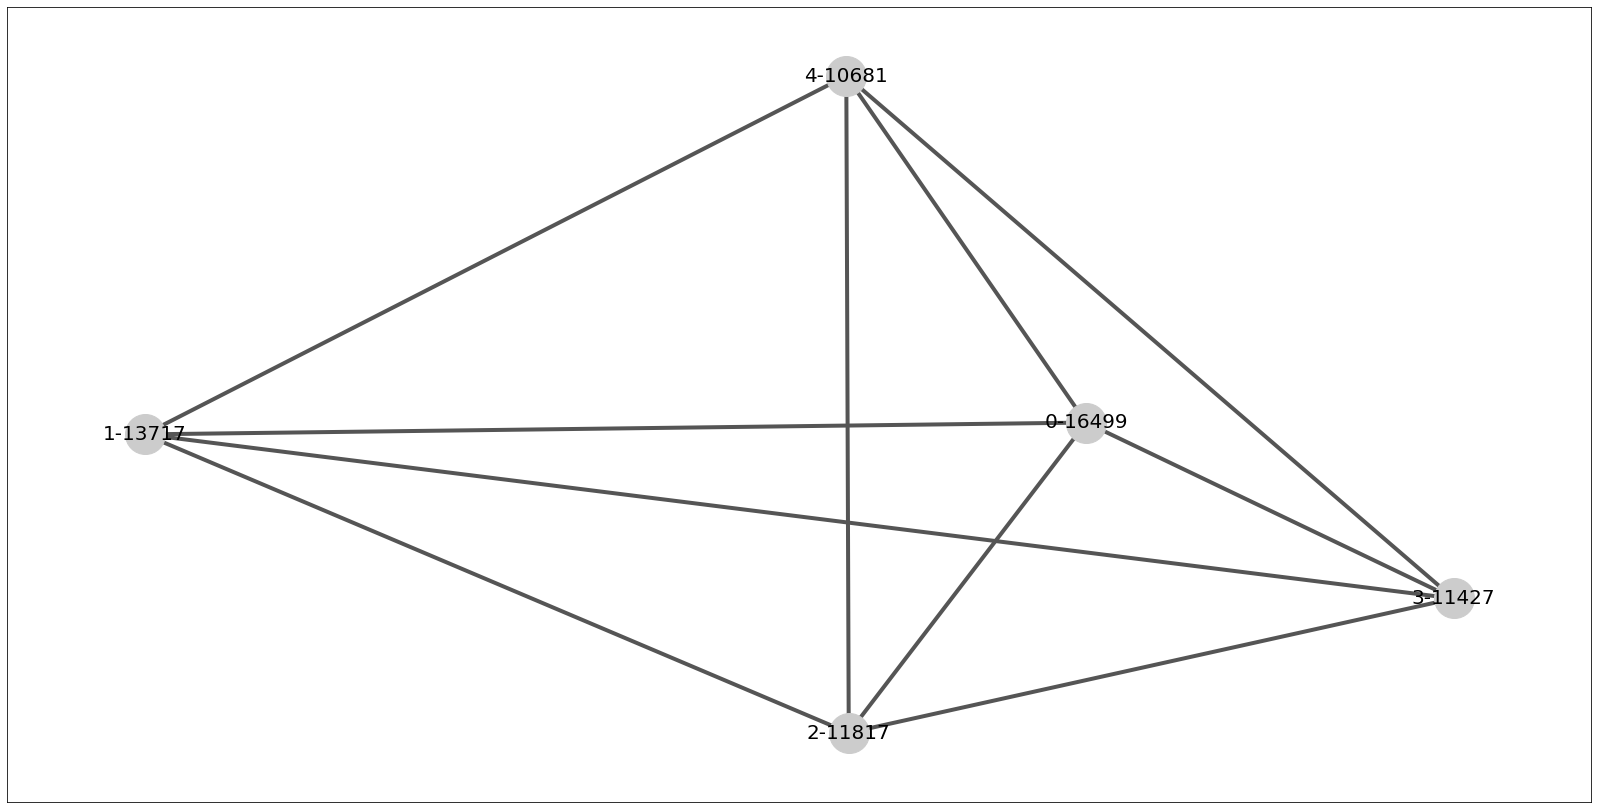

In [92]:
draw_graph(use_network(5, select_tsp_heroes))
#CAPTION Visualize five heroes

## Knapsack

In [93]:
data = pd.read_csv('./data/hero-network.csv')

size = 8
heroes = select_heroes(size)

# count the overall appearences of the heroes
count_series1 = data.groupby(['hero1']).size()
count_series2 = data.groupby(['hero2']).size()
total_appearences = dict(sorted([row for row in count_series1.add(count_series2, fill_value=0).to_dict().items() if row[0] in heroes.keys()], key=lambda row: heroes[row[0]]))
total_appearences
#CAPTION Counting the total appearences

{'MEDUSA/MEDUSALITH AM': 2257.0,
 'ARCLIGHT/PHILLIPA SO': 415.0,
 'WOLVERINE/LOGAN ': 10353.0,
 'SCARLET WITCH/WANDA ': 9911.0,
 'ARAGORN': 346.0,
 'OVERMIND/GROM': 243.0,
 'BATTLEAXE/': 142.0,
 'ION/': 86.0}

In [94]:
# filter the relations from the raw data
relations = data[(data.hero1.isin(heroes.keys())) & (data.hero2.isin(heroes.keys()))]
relations = pd.DataFrame(np.sort(relations.values, axis=1), columns=relations.columns)

count_network1 = relations.groupby(['hero1']).size()
count_network2 = relations.groupby(['hero2']).size()
network_appearences = dict(sorted([row for row in count_network1.add(count_network2, fill_value=0).to_dict().items()], key=lambda row: select_heroes(size)[row[0]]))
network_appearences
#CAPTION Counting the appearences inside the network

{'MEDUSA/MEDUSALITH AM': 23.0,
 'ARCLIGHT/PHILLIPA SO': 14.0,
 'WOLVERINE/LOGAN ': 54.0,
 'SCARLET WITCH/WANDA ': 71.0,
 'ARAGORN': 10.0,
 'OVERMIND/GROM': 7.0,
 'BATTLEAXE/': 5.0,
 'ION/': 4.0}

In [95]:
from qiskit_optimization.applications import Knapsack

max_weight=10000

knapsack = Knapsack(
    values=list(network_appearences.values()),
    weights=list(total_appearences.values()),
    max_weight=max_weight)

qaoa_optimizer = MinimumEigenOptimizer(QAOA(
    quantum_instance=QuantumInstance(Aer.get_backend("qasm_simulator"))
))

result = qaoa_optimizer.solve(
    knapsack.to_quadratic_program()
)
print("solution:", knapsack.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)
#CAPTION Solving the Knapsack problem

solution: [3, 7]
time: 429.87523770332336


In [ ]:
max_weight=10000

def to_perf_knapsack(key, graph):
    (solution, eigenvalues) = sol_eigen(key)
    
    value = sum(graph.edges[edge]['weight']*(int(solution[edge[0]])+int(solution[edge[1]])) for edge in graph.edges)
    cost = sum(int(solution[node]) * graph.nodes[node]['weight'] for node in graph.nodes)
    
    performance = (cost**2 if cost > max_weight else 0)-value
        
    return performance


(result, cache, draw) = solve_problem_with_qaoa(
    use_network(8),
    biased_ev(to_perf_knapsack),
    Aer.get_backend('qasm_simulator'),
    precision=100,
    repititions=3
)
#CAPTION Solve the Knapsack problem